# Stromverbrauchsprognose unter Verwendung von Wetterdaten
In diesem Projekt soll anhand von bereitgestellten Wetter- und Energieverbrauchsdaten der zukünftige Energieverbrauch in 1 Stunde bzw. 24 Stunden prognostiziert werden.  
Die Prognosen sollen mittels verschiedener Modelle erstellt und deren Ergebnisse anschließend miteinander verglichen werden.

## Setup

In [1]:
#Basic Libraries
import numpy as np 
import pandas as pd 
import random

#Statistical Libraries
import statistics as st  

#Plotting Libraries
import matplotlib.pyplot as plt  
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf

#Statistical Modeling Libraries
import statsmodels.api as sm 
from scipy.stats import linregress 

#Machine Learning Libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.ensemble import BaggingRegressor 
from sklearn.tree import DecisionTreeRegressor

#Deep Learning Libraries
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.optimizers import SGD
import tensorflow as tf

#IPython Settings
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = 'all'  #Show multiple outputs within one kernel

#Matplotlib Settings
%matplotlib inline  

# 1. Überblick und  Datenbereinigung 
Hierzu stehen uns zwei Datensätze zur Verfügung:
* `'SystemLevelSummer.csv'` enthält Informationen zum Stromverbrauch, die im Wesentlichen vorhergesagt werden sollen.
* `'weatherDFLocalSummer.csv'` enthält Wetterinformationen  
  
Dabei handelt es sich um Daten aus Stadtteilen San Franciscos.

## 1.1 Laden der Datensätze

In [2]:
powerDF = pd.read_csv('./data/SystemLevelSummer.csv')
weatherDF = pd.read_csv('./data/WeatherLocalSummer.csv')

In [3]:
powerDF.columns
powerDF.head()

Index(['#DATE', ' TOTAL_LOAD'], dtype='object')

#DATE     TOTAL_LOAD
0  2011-06-01 00:15  639691.499583
1  2011-06-01 00:30  624777.006874
2  2011-06-01 00:45  610658.780201
3  2011-06-01 01:00  597351.542302
4  2011-06-01 01:15  583547.506936

Hierbei ist zu erkennen, dass der Datensatz `powerDF` für 'SystemLevelSummer.csv' die Spalten `'#DATE'` für das Datum  
und `'#TOTAL_LOAD'` für den Gesamtstromverbrauch enthält. 

In [4]:
weatherDF.columns
weatherDF.head()

Index(['# DATE', ' TEMPERATURE [F]', ' HUMIDITY [%]', ' PRESSURE [inHg]',
       ' WIND_SPEED [m/s]', ' RAINFALL [mm]'],
      dtype='object')

# DATE   TEMPERATURE [F]   HUMIDITY [%]   PRESSURE [inHg]  \
0  2011-05-30 17:00            86.635         51.563            29.941   
1  2011-05-30 18:00            84.931         56.044            29.945   
2  2011-05-30 19:00            83.100         61.551            29.952   
3  2011-05-30 20:00            80.823         69.142            29.967   
4  2011-05-30 21:00            79.305         75.395            29.983   

    WIND_SPEED [m/s]   RAINFALL [mm]  
0              7.523             0.0  
1              7.453             0.0  
2              6.930             0.0  
3              6.979             0.0  
4              6.677             0.0

Der Datensatz `weatherDF` für 'WeatherLocalSummer.csv' besitzt die Spalten `'# DATE'` - Datum, `' TEMPERATURE [F]'` - Temperatur, `' HUMIDITY [%]'` - Luftfeuchtigkeit,  
`' PRESSURE [inHg]'` - Druck, `' WIND_SPEED [m/s]'` - Windgeschwindigkeit, `' RAINFALL [mm]'` - Niederschlag

## 1.2 Überarbeitung der Datenstruktur
Nachfolgend sollen die Datensätze so überarbeitet werden, dass diese im weiteren Verlauf sinnvoll und bequem untersucht werden können.  

### 1.2.1 Allgemeine Änderungen
Zunächst werden überflüssige Leerzeichen in den Spaltennamen entfernt, um die Lesbarkeit zu verbessern.  
   
Anschließend wird die Spalte `'#DATE'` in ein Datetime-Format umgewandelt und als Index des DataFrames festgelegt, um einen Bezug zur Zeitskala herzustellen.  
Dabei wird sichergestellt, dass die Daten in aufsteigender Reihenfolge sortiert sind.  
  
Zur besseren Übersicht und für zukünftige Modelle werden zusätzlich die Stunden, Tage und Monate extrahiert.

In [5]:
def generalModification(df):
    #General Modifications---------------------
    df.columns = df.columns.str.replace(" ", "")

    #Date Modifications------------------------
    df['#DATE'] = pd.to_datetime(df['#DATE'])
    df = df.set_index('#DATE').sort_index()
    df.index = df.index.tz_localize('UTC') #ensure timezone-aware format for further modifications

    #Separate the datetime in separate columns
    df['MONTH'] = df.index.month
    df['DAY'] = df.index.day
    df['HOUR'] = df.index.hour

    return df

In [6]:
powerDF = generalModification(powerDF)
weatherDF = generalModification(weatherDF)

### 1.2.2 Überprüfung auf Datenlücken
Wir wollen NaN-Werte in unserem Datensatz ausschließen, da diese das Arbeiten mit den Daten erschweren und beim Auftreten genauer betrachtet werden müssten.

In [7]:
#detect NaN values in the two df
any(map(lambda df: df.isna().any().any(), [powerDF, weatherDF]))

False

Zudem überprüfen wir gleich, ob wir Lücken innerhalb der Daten haben, also ob wir es mit einer kontinuierlichen Datenerfassung zu tun haben.
Dazu betrachten wir jeweils die Differenz zweier aufeinanderfolgender Einträge und bestimmen, ob diese von der zu erwartenden Differenz abweicht. Diese leiten wir aus den Tabellen in 1.1 ab.

Dabei erwarten wir folgende Abstände zwischen zwei Einträgen:

* `powerDF` - 15 min
* `weatherDF` - 60 min
  

In [8]:
#Ensure equal time periods between data
(powerDF.index.diff()[1:] == pd.Timedelta(minutes=15)).all()
(weatherDF.index.diff()[1:] == pd.Timedelta(minutes=60)).all()

True

True

Die Zeitabstände zwischen je zwei Datenpunkten sind stets identisch, somit sind die Daten kontinuierlich erfasst worden.

### 1.2.3 Spezielle Überarbeitung powerDF
Da die Zeitabstände in `powerDF` 15 Minuten betragen und im `weatherDF` stündlich aufgenommene Messwerte vorliegen, soll im Folgenden der DataFrame powerDF überarbeitet bzw. an den Wetter-Datensatz angepasst werden.  
Da es in beiden Datensätzen keine Lücken gibt, können die einzelnen Werte in `powerDF` zu Stundenwerten zusammengefasst werden.

Dabei verwerfen wir den ersten und letzten Eintrag, da wir hierfür keine volle Stunde erhalten würden und somit die Punkte nicht mit dem Rest vergleichbar wären.

In [9]:
#Resample the TOTAL_LOAD values to the summed load and keep HOUR, DAY and MONTH
powerDF = powerDF.resample('h').agg({
    'TOTAL_LOAD': 'sum',
    'HOUR' : 'first',
    'MONTH': 'first',
    'DAY': 'first'
})[1:-1]

Da der Datensatz zum Stromverbrauch ohne Einheiten vorliegt, wird nun durch Internet-Recherchen die passende Einheit identifiziert.  
  
Laut "Pacific Gas & Electric Company - PG&E" lag 2011 der durchschnittliche [tägliche Stromverbrauch in San Francisco](https://www.cbsnews.com/sanfrancisco/news/good-question-how-much-electricity-does-san-francisco-use-daily/) bei 18.000 MWh. Da sich unsere Daten nur auf einen Teil San Franciscos beziehen, sollten die Werte des täglichen Verbrauchs kleiner sein als 18.000 MWh.   
Der tägliche durchschnittliche Verbrauch in unserem Datensatz wäre gerundet 90.000.000 (siehe Code im Anschluss). Wäre hierbei die Einheit kWh, läge der durchschnittliche Verbrauch bei 90.000 MWh, was deutlich mehr ist als 18 000 MWh. Somit muss die Einheit kleiner sein.  
Bei der Wahl von Wh wäre der Verbrauch ca. 90 MWh. Dies macht am meisten Sinn von der Größenordnung her; weshalb angenommen wird, dass die Daten in der Einheit Wh vorliegen.  
  
Um eine Größenordnung für die Anzahl an Personen zu bekommen, auf die sich der Datensatz bezieht, wird nun berechnet wie viel Wh eine Person von den ca. 800.000 Einwohnern verbraucht, indem der tägliche Stromverbrauch durch die Anzahl der Personen geteilt wird (was zwar nicht dem richtigen Verbrauch entspricht, da der Großteil des durchschnittlichen Stromverbrauchs auf Gewerbe etc. zurückzuführen ist, aber hier obligatorisch gemacht werden kann).  
Der tägliche Verbrauch wäre mit dieser Berechnung 22,5 kWh pro Person. Durch die Division der vorher berechneten 90.000 kWh durch 22,5 kWh erhält man als Anzahl 4.000 Personen.  
Geht man von einem [durchschnittlichen pro Kopf Verbrauch von 3,6 kWh](https://www.gasag.de/magazin/neudenken/stromverbrauch-pro-tag#title-0) und einem reinen Wohngebiet aus, so kommt man auf eine Anzahl von etwa 25.000 Personen.  

In [10]:
#calculate the daily power consumption (drop last day, because not complete)
powerDF_daily = powerDF.resample('d').sum()[:-1]

#calculate the mean of the daily consumption 
powerDF_daily['TOTAL_LOAD'].mean()


89828020.67522785


Da die Messwerte für den Stromverbrauch aktuell in der vorliegenden Einheit Wh sehr groß sind, soll im Folgenden die Einheit auf MWh geändert werden. Anschließend werden die Werte auf 3 Nachkommastellen gerundet, um übersichtlichere Daten zu bekommen.  
Dadurch erhält man einen Genauigkeitsverlust von maximal 500 Wh, was ungefähr dem durchschnittlichen [täglichen Stromverbrauch von 2 Kühlschränken](https://praxistipps.chip.de/stromverbrauch-beim-kuehlschrank-pro-tag-so-hoch-ist-er_149698) entspricht, die leicht vernachlässigbar sind.  
Die dazugehörige Berechnung wäre, den jährlichen durchschnittlichen Verbrauch eines Kühlschanks von 91.000 Wh durch 365 Tage zu teilen, was also ca. 250 Wh pro Tag sind. Auf die 24h hochgerechnet wären es somit 48 Kühlschränke von 25.000 Personen. Eine Rundung ist somit durchaus legitim.

In [11]:
#new unit and round the data
powerDF['TOTAL_LOAD'] = powerDF['TOTAL_LOAD']/(1000**2)
powerDF['TOTAL_LOAD'] = powerDF['TOTAL_LOAD'].round(3)
powerDF_daily['TOTAL_LOAD'] = powerDF_daily['TOTAL_LOAD']/(1000**2)
powerDF_daily['TOTAL_LOAD'] = powerDF_daily['TOTAL_LOAD'].round(3)

### 1.2.4 Spezielle Überarbeitung weatherDF
Da in Deutschland bei Temperaturmessungen die Einheit Celsius gängiger als Fahrenheit ist, wird im Folgenden die Spalte `"TEMPERATURE[F]"` umgwandelt.  
Ebenso wird bar als Einheit für den Druck verwendet und `'PRESSURE[bar]'` angepasst.

In [12]:
#Adjust Fahrenheit to Celsius
weatherDF['TEMPERATURE[F]'] = (weatherDF['TEMPERATURE[F]']-32)/1.8
weatherDF = weatherDF.rename(columns={'TEMPERATURE[F]': 'TEMPERATURE[C]'})

#Adjust inHg to bar
weatherDF['PRESSURE[inHg]'] = (weatherDF['PRESSURE[inHg]'])*0.03386
weatherDF = weatherDF.rename(columns={'PRESSURE[inHg]': 'PRESSURE[bar]'})

## 1.3 Überblick über die Daten 
Nun soll sich von den überarbeiteten Datensätzen ein detailierterer Überblick verschaffen werden, um sie gegebenenfalls weiter aneinander anzupassen.


In [13]:
powerDF.columns
powerDF

Index(['TOTAL_LOAD', 'HOUR', 'MONTH', 'DAY'], dtype='object')

TOTAL_LOAD  HOUR  MONTH  DAY
#DATE                                                  
2011-06-01 01:00:00+00:00       2.313     1      6    1
2011-06-01 02:00:00+00:00       2.155     2      6    1
2011-06-01 03:00:00+00:00       2.067     3      6    1
2011-06-01 04:00:00+00:00       2.086     4      6    1
2011-06-01 05:00:00+00:00       2.222     5      6    1
...                               ...   ...    ...  ...
2011-08-31 19:00:00+00:00       4.691    19      8   31
2011-08-31 20:00:00+00:00       4.468    20      8   31
2011-08-31 21:00:00+00:00       4.089    21      8   31
2011-08-31 22:00:00+00:00       3.647    22      8   31
2011-08-31 23:00:00+00:00       3.257    23      8   31

[2207 rows x 4 columns]

In [14]:
weatherDF.columns
weatherDF

Index(['TEMPERATURE[C]', 'HUMIDITY[%]', 'PRESSURE[bar]', 'WIND_SPEED[m/s]',
       'RAINFALL[mm]', 'MONTH', 'DAY', 'HOUR'],
      dtype='object')

TEMPERATURE[C]  HUMIDITY[%]  PRESSURE[bar]  \
#DATE                                                                   
2011-05-30 17:00:00+00:00       30.352778       51.563       1.013802   
2011-05-30 18:00:00+00:00       29.406111       56.044       1.013938   
2011-05-30 19:00:00+00:00       28.388889       61.551       1.014175   
2011-05-30 20:00:00+00:00       27.123889       69.142       1.014683   
2011-05-30 21:00:00+00:00       26.280556       75.395       1.015224   
...                                   ...          ...            ...   
2011-09-01 12:00:00+00:00       31.492222       55.515       1.013938   
2011-09-01 13:00:00+00:00       32.403889       49.891       1.013193   
2011-09-01 14:00:00+00:00       33.896667       41.848       1.012245   
2011-09-01 15:00:00+00:00       34.738333       37.137       1.011330   
2011-09-01 16:00:00+00:00       35.065556       36.018       1.010619   

                           WIND_SPEED[m/s]  RAINFALL[mm]  MONTH  DAY  HOUR  
#DATE                                                                       
2011-05-30 17:00:00+00:00            7.523           0.0      5   30    17  
2011-05-30 18:00:00+00:00            7.453           0.0      5   30    18  
2011-05-30 19:00:00+00:00            6.930           0.0      5   30    19  
2011-05-30 20:00:00+00:00            6.979           0.0      5   30    20  
2011-05-30 21:00:00+00:00            6.677           0.0      5   30    21  
...                                    ...           ...    ...  ...   ...  
2011-09-01 12:00:00+00:00            5.650           0.0      9    1    12  
2011-09-01 13:00:00+00:00            5.407           0.0      9    1    13  
2011-09-01 14:00:00+00:00            5.461           0.0      9    1    14  
2011-09-01 15:00:00+00:00            5.162           0.0      9    1    15  
2011-09-01 16:00:00+00:00            5.534           0.0      9    1    16  

[2256 rows x 8 columns]

Aus dem Datensatz mit dem Stromverbrauch (aktuelle Einheit MWh) ist zu erkennen, dass die Messwerte im Zeitraum vom 01.06.2011 bis 01.09.2011 aufgezeichnet wordem sind. Aktuell mit einer Differenz von einer Stunde, die davor allerdings 15min betrug. 

Der Datensatz mit den Wetterdaten bezieht sich hingegen auf den Zeitraum vom 30.05.2011, 17:00 Uhr bis zum 01.09.2011, 16:00 Uhr. Daher enthält dieser Datensatz mehr Werte als der erste, was sich auch im unterschiedlichen Zählwert in der Datenzusammenfassung widerspiegelt.

In beiden Datensätzen werden die drei Sommermonate Juni, Juli und August des Jahres 2011 vollständig abgedeckt. 
Die Wetterdaten enthalten stündliche Messwerte zu Temperatur (in °C), Luftfeuchtigkeit (in %), Druck (in bar), Windgeschwindigkeit (in m/s) und Niederschlag (in mm).

In [15]:
powerDF.describe()
weatherDF.describe()

TOTAL_LOAD         HOUR        MONTH          DAY
count  2207.000000  2207.000000  2207.000000  2207.000000
mean      3.746179    11.505211     7.011328    15.843679
std       0.969472     6.920992     0.814287     8.852603
min       1.925000     0.000000     6.000000     1.000000
25%       2.855500     6.000000     6.000000     8.000000
50%       3.707000    12.000000     7.000000    16.000000
75%       4.583000    17.500000     8.000000    23.500000
max       5.720000    23.000000     8.000000    31.000000

TEMPERATURE[C]  HUMIDITY[%]  PRESSURE[bar]  WIND_SPEED[m/s]  \
count     2256.000000  2256.000000    2256.000000      2256.000000   
mean        28.996319    64.212354       1.012991         3.917266   
std          3.580114    18.236110       0.002548         1.932054   
min         19.231667    21.227000       1.006285         0.000000   
25%         26.172083    47.808250       1.011322         2.487000   
50%         28.267222    66.830500       1.012837         3.733500   
75%         31.836528    81.200250       1.014412         5.313000   
max         39.385556    98.210000       1.022470        11.592000   

       RAINFALL[mm]        MONTH          DAY         HOUR  
count   2256.000000  2256.000000  2256.000000  2256.000000  
mean       0.007017     6.998227    15.930408    11.500000  
std        0.059717     0.856951     9.026840     6.923721  
min       -0.180000     5.000000     1.000000     0.000000  
25%        0.000000     6.000000     8.000000     5.750000  
50%        0.000000     7.000000    16.000000    11.500000  
75%        0.000000     8.000000    24.000000    17.250000  
max        1.800000     9.000000    31.000000    23.000000

Hier sind die deskriptiven Statistiken der beiden Datensätze zu erkennen. Besonders relevant für uns sind die Werte mean (Durchschnitt), std (Standardabweichung), min (minimaler Wert) und max (maximaler Wert). So können wir mögliche Auffälligkeiten erkennen und unseren Fokus darauf legen.

Aktuell gibt es keine starken Auffälligkeiten, außer beim Niederschlag. Hier beträgt der `min`-Wert ~0.18, was einen negativen Niederschlag bedeuten würde. Dies ist auf allen Ebenen unlogisch und muss später genauer untersucht werden.


Im Folgenden werden die einzelnen Messwerte noch in Abhängigkeit von der Zeit geplottet, um diese visuell zu analysieren. 

In [16]:
def plotDF(df, column, title, y_axis):
    plt.figure(figsize=(12, 3))

    plt.plot(df.index, df[column])

    #Adjust the plot
    plt.title(title)
    plt.xlabel('Zeitskala')
    plt.ylabel(y_axis)
    plt.grid(True)
    plt.show()


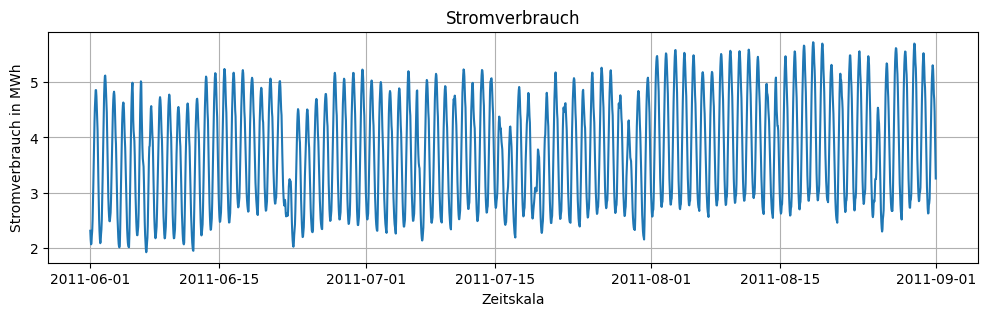

In [17]:
plotDF(powerDF, 'TOTAL_LOAD', 'Stromverbrauch', 'Stromverbrauch in MWh')

Der Plot zeigt den Stromverbrauch in Megawattstunden (MWh) über den betrachteten Zeitraum und zeigt den Verbrauchswert, der zwischen etwa 2 MWh und 6 MWh liegt.  
Der Stromverbrauch schwankt stark und zeigt eine zyklische Struktur, was auf regelmäßige Schwankungen im Tages- oder Wochenrhythmus hindeuten könnte.  
Es scheint einen allgemeinen Trend zu geben, wobei der Stromverbrauch zwischen Anfang Juni und Ende August leicht zunimmt und dann in der letzten Augustwoche ein leichter Rückgang zu erkennen ist.  

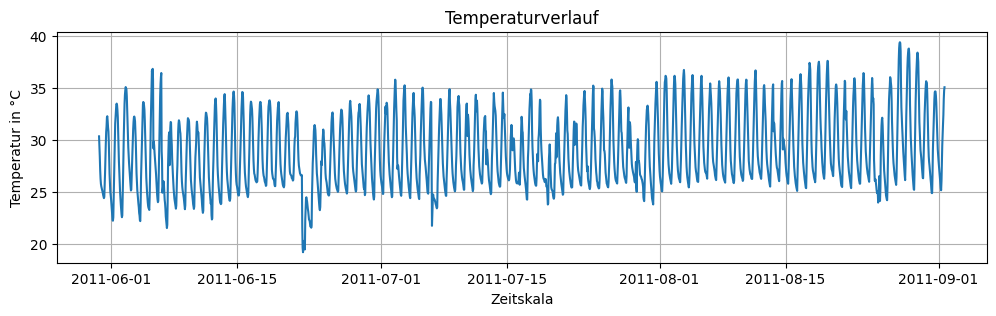

In [18]:
plotDF(weatherDF, 'TEMPERATURE[C]', 'Temperaturverlauf', 'Temperatur in °C')

Hier ist der Temperaturverlauf in °C über den vorliegenden Zeitraum dargestellt und zeigt, dass die Temperaturen ungefähr zwischen 19°C und 39°C liegen. Ähnlich wie beim Stromverbrauch sind stärkere Schwankungen sowie eine periodische Struktur zu beobachten, was auf einen Tages- oder Wochenrhythmus hinweist. Es ist zu erkennen, dass die Temperatur gegen Ende des Zeitraums zunimmt und im August, abgesehen von einer Schwankung, ihre Höchstwerte erreicht.

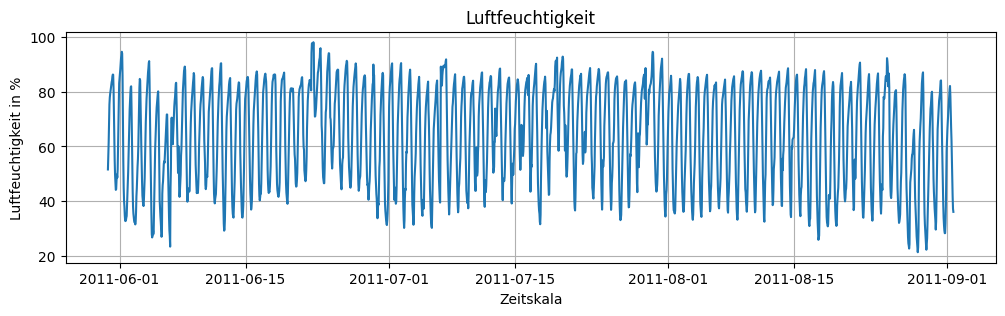

In [19]:
plotDF(weatherDF, 'HUMIDITY[%]', 'Luftfeuchtigkeit', 'Luftfeuchtigkeit in %')

Im Plot zur Luftfeuchtigkeit in % erkennt man ebenfalls eine zyklische Struktur, wobei die Werte zwischen 20% und 100% liegen. Auch hier sind einige Schwankungen zu beobachten. Dabei ist ein leichter Trend erkennbar, dass die Luftfeuchtigkeit tendenziell im Laufe der Zeit etwas abnimmt.

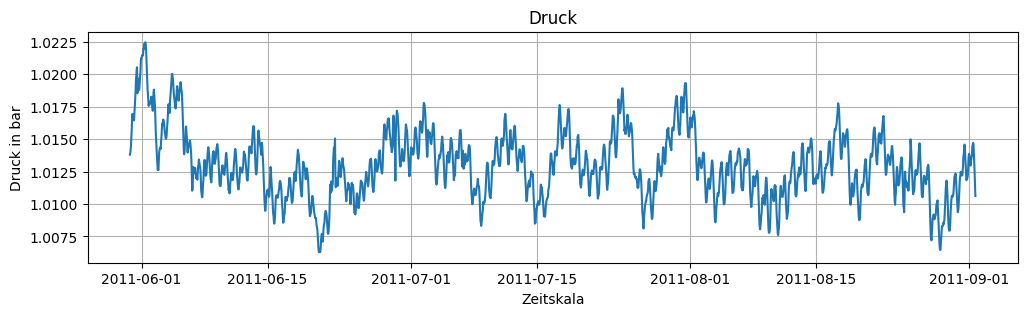

In [20]:
plotDF(weatherDF, 'PRESSURE[bar]', 'Druck', 'Druck in bar')

Der Plot zeigt deutliche Schwankungen des Luftdrucks in bar über die gesamte Zeitspanne. Diese Schwankungen sind typischerweise in Wetterdaten zu beobachten und spiegeln die natürliche Variabilität des atmosphärischen Drucks wider.  
Der Druck liegt zwischen etwa 1.0075 bar und 1.0225 bar. Dies entspricht normalen atmosphärischen Druckwerten auf Meereshöhe.

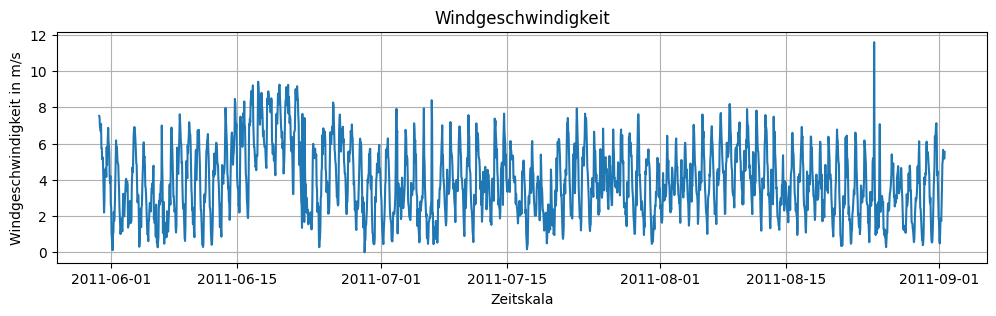

In [21]:
plotDF(weatherDF, 'WIND_SPEED[m/s]', 'Windgeschwindigkeit', 'Windgeschwindigkeit in m/s')

Die Windgeschwindigkeit in m/s zeigt signifikante tägliche Schwankungen. Es gibt keine Perioden langer konstanter Windgeschwindigkeit; stattdessen sehen wir kontinuierliche Änderungen über den gesamten Zeitabschnitt.  
Es gibt einige Spitzenwerte, bei denen die Windgeschwindigkeit über 10 m/s liegt. Dies deutet auf gelegentlich sehr starke Winde hin.

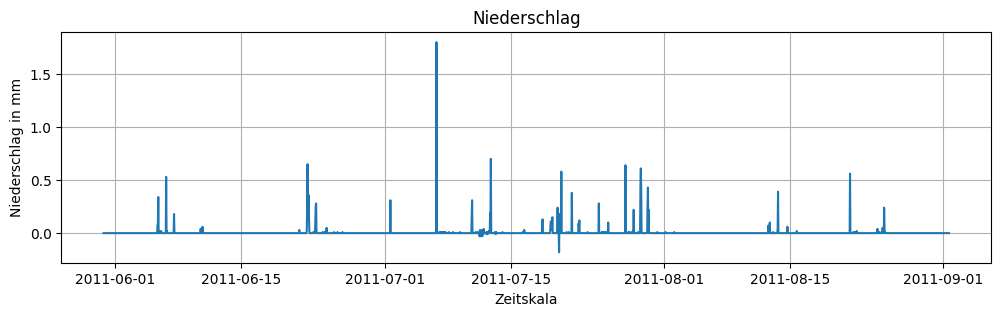

In [22]:
plotDF(weatherDF, 'RAINFALL[mm]', 'Niederschlag', 'Niederschlag in mm')

Die Niederschläge in mm sind unregelmäßig über den gesamten Zeitraum verteilt. Es gibt keine konstanten oder regelmäßigen Niederschläge, sondern sie treten sporadisch auf.

Der höchste Niederschlagspunkt liegt bei über 1,5 mm und tritt Anfang Juli auf. Dies ist ein signifikanter Ausreißer im Vergleich zu den anderen Niederschlagswerten.
Weitere kleinere Spitzen sind ebenfalls sichtbar, jedoch sind sie meistens unter 0,5 mm.  
Es gibt längere Phasen ohne jeglichen Niederschlag, insbesondere in der zweiten Hälfte des Juni und in den ersten beiden Wochen des Augusts.

  
    
Nach der Analyse aller Messwerte fällt auf, dass sowohl beim Stromverbrauch als auch bei den Wetterdaten zu Temperatur, Luftfeuchtigkeit, Windgeschwindigkeit und Niederschlag im gleichen Zeitraum vom 15.06. bis 01.07. Auffälligkeiten zu erkennen sind: Im Vergleich zu den restlichen Daten herrschten eine ziemlich hohe Windgeschwindigkeit sowie eine hohe Luftfeuchtigkeit und hoher Niederschlag, wohingegen die Temperatur eher niedrig war.

Die bisherigen Beobachtungen sowie die genauen Daten bzw. Zeiten werden jedoch erst im späteren Verlauf der Datenanalyse näher untersucht.

## 1.3 Datenbereinigung
Damit für die weitere Arbeit mit den Daten bzw. für die Erstellung der Prognosen sinnvolle Messwerte vorliegen, werden die bisherigen bereits überarbeiteten Daten bereinigt.

### 1.3.1 Einschränkung des Zeitintervalls
Die Stromverbrauchsdaten und Wetterdaten können nur in Kombination sinnvoll betrachtet werden. Dementsprechend ist nur der Zeitraum relevant, in dem sich die Datenerfassung überschneidet.  
Wie bereits festgestellt wurde, stimmen Beginn und Ende der Datenerfassung in den beiden Datensätzen jedoch nicht überein. Dies soll nun vereinheitlicht werden, indem wir den späteren Startzeitpunkt und den früheren Endzeitpunkt der beiden Datensätze als gültiges Intervall wählen.

In [23]:
powerDF.iloc[[1, -1]]
weatherDF.iloc[[1, -1]]

TOTAL_LOAD  HOUR  MONTH  DAY
#DATE                                                  
2011-06-01 02:00:00+00:00       2.155     2      6    1
2011-08-31 23:00:00+00:00       3.257    23      8   31

TEMPERATURE[C]  HUMIDITY[%]  PRESSURE[bar]  \
#DATE                                                                   
2011-05-30 18:00:00+00:00       29.406111       56.044       1.013938   
2011-09-01 16:00:00+00:00       35.065556       36.018       1.010619   

                           WIND_SPEED[m/s]  RAINFALL[mm]  MONTH  DAY  HOUR  
#DATE                                                                       
2011-05-30 18:00:00+00:00            7.453           0.0      5   30    18  
2011-09-01 16:00:00+00:00            5.534           0.0      9    1    16

In [24]:
#Determine start and endtime 
start_date = max(powerDF.index.min(), weatherDF.index.min())
end_date = min(powerDF.index.max(), weatherDF.index.max())

#Crop the dataframes according to the overlapping intervall
powerDF = powerDF.loc[start_date:end_date]
weatherDF = weatherDF.loc[start_date:end_date]

### 1.3.2 Bearbeitung unlogischer Werte
Im Großen und Ganzen haben wir logisch erscheinende Daten. Allerdings gibt es noch einige Ausreißer, die physikalisch nicht nachvollziehbar sind.

So erhalten wir beispielsweise für den Niederschlag, wie bereits beobachtet, in einigen Fällen negative Werte. Diese sollen nun detektiert und untersucht werden, um zu entscheiden, wie am besten mit ihnen umgegangen werden soll.

Je nach Beschaffenheit der Daten wollen wir diese beispielsweise:

* durch vordefinierte Standardwerte ersetzen, z.B. 0 mm,
* durch das positive Inverse ersetzen,
* durch den Durchschnitt umliegender Werte ersetzen.

Natürlich könnten wir die betreffenden Reihen auch verwerfen. Wie wir jedoch später sehen werden, steht dieser Parameter nicht wirklich im Zusammenhang mit dem zu prognostizierenden Stromverbrauch und wird tendenziell als Ganzes verworfen. Da die Kontinuität der Daten für die Prognose wichtiger ist, werden nur die fehlerhaften Daten angepasst.  

In [25]:
negativRainDF = weatherDF[weatherDF['RAINFALL[mm]']<0]
negativRainDF

len(negativRainDF)

TEMPERATURE[C]  HUMIDITY[%]  PRESSURE[bar]  \
#DATE                                                                   
2011-07-11 12:00:00+00:00       32.641667       45.994       1.016139   
2011-07-11 14:00:00+00:00       34.343889       37.866       1.015055   
2011-07-11 19:00:00+00:00       31.836111       49.500       1.013057   
2011-07-11 22:00:00+00:00       28.277222       67.671       1.014818   
2011-07-12 07:00:00+00:00       25.927778       85.567       1.014750   
2011-07-12 09:00:00+00:00       28.318889       72.986       1.015563   
2011-07-13 07:00:00+00:00       24.918333       88.564       1.013565   
2011-07-20 08:00:00+00:00       25.977222       85.412       1.013802   

                           WIND_SPEED[m/s]  RAINFALL[mm]  MONTH  DAY  HOUR  
#DATE                                                                       
2011-07-11 12:00:00+00:00            3.053         -0.03      7   11    12  
2011-07-11 14:00:00+00:00            3.484         -0.03      7   11    14  
2011-07-11 19:00:00+00:00            6.569         -0.03      7   11    19  
2011-07-11 22:00:00+00:00            5.191         -0.01      7   11    22  
2011-07-12 07:00:00+00:00            2.129         -0.01      7   12     7  
2011-07-12 09:00:00+00:00            4.433         -0.01      7   12     9  
2011-07-13 07:00:00+00:00            1.511         -0.01      7   13     7  
2011-07-20 08:00:00+00:00            1.716         -0.18      7   20     8

8

Wir erhalten für acht Reihen negative Niederschlagswerte.

Vergleichen wir die umliegenden Niederschlagswerte mit den negativen, fällt auf, dass abgesehen vom Vorzeichen die Größenordnung sehr ähnlich oder sogar gleich ist. Unten aufgeführt sind die Reihen der letzten drei betroffenen Werte, einschließlich der unmittelbar umliegenden Werte. Ähnliche Beobachtungen lassen sich auch für die restlichen Fälle feststellen.

Dies legt nahe, dass nur das Vorzeichen falsch ist, die Zahlenwerte jedoch korrekt sind. Wir entschließen uns daher, jeweils den Betrag des Niederschlags als tatsächlichen Wert anzunehmen, um das Problem zu beheben.

In [26]:
for index in negativRainDF.index[-3:]:
    #Current index position in the weatherDF of correspoding negativRainDF
    idx_pos = weatherDF.index.get_loc(index)

    #DF with surrounding rows
    weatherDF.iloc[idx_pos-1:idx_pos +2]


TEMPERATURE[C]  HUMIDITY[%]  PRESSURE[bar]  \
#DATE                                                                   
2011-07-12 08:00:00+00:00       27.197222       79.320       1.015224   
2011-07-12 09:00:00+00:00       28.318889       72.986       1.015563   
2011-07-12 10:00:00+00:00       29.417222       66.580       1.015868   

                           WIND_SPEED[m/s]  RAINFALL[mm]  MONTH  DAY  HOUR  
#DATE                                                                       
2011-07-12 08:00:00+00:00            3.014          0.01      7   12     8  
2011-07-12 09:00:00+00:00            4.433         -0.01      7   12     9  
2011-07-12 10:00:00+00:00            3.390          0.01      7   12    10

TEMPERATURE[C]  HUMIDITY[%]  PRESSURE[bar]  \
#DATE                                                                   
2011-07-13 06:00:00+00:00       24.800000       88.396       1.013227   
2011-07-13 07:00:00+00:00       24.918333       88.564       1.013565   
2011-07-13 08:00:00+00:00       26.798889       80.056       1.014039   

                           WIND_SPEED[m/s]  RAINFALL[mm]  MONTH  DAY  HOUR  
#DATE                                                                       
2011-07-13 06:00:00+00:00            1.989          0.00      7   13     6  
2011-07-13 07:00:00+00:00            1.511         -0.01      7   13     7  
2011-07-13 08:00:00+00:00            2.797          0.00      7   13     8

TEMPERATURE[C]  HUMIDITY[%]  PRESSURE[bar]  \
#DATE                                                                   
2011-07-20 07:00:00+00:00       24.524444       92.167       1.013261   
2011-07-20 08:00:00+00:00       25.977222       85.412       1.013802   
2011-07-20 09:00:00+00:00       27.728889       74.943       1.014107   

                           WIND_SPEED[m/s]  RAINFALL[mm]  MONTH  DAY  HOUR  
#DATE                                                                       
2011-07-20 07:00:00+00:00            0.950          0.00      7   20     7  
2011-07-20 08:00:00+00:00            1.716         -0.18      7   20     8  
2011-07-20 09:00:00+00:00            3.259          0.18      7   20     9

In [27]:
#Adjust negative value to positive value
weatherDF.loc[:,'RAINFALL[mm]'] = weatherDF.loc[:,'RAINFALL[mm]'].abs()

# 2. Datenanalyse

## 2.0 Kombination beider Datensätze 
Ab hier werden wir Funktionen verwenden, für die es sinnvoll ist, alle Daten in einer Struktur auffinden zu können. Da die Zeiträume und Erfassungsabstände unserer Datensätze übereinstimmen, können wir diese einfach am Index mergen.

Zudem definieren wir eine Liste mit den Features und eine mit den Targets:

* Features sind dabei alle Wetterdaten und aktuellen Stromdaten.
* Targets bleiben vorerst leer, sollen aber später die zukünftigen Werte der Stromdaten enthalten.

In [28]:
necessaryCol = powerDF.columns.difference(weatherDF.columns) #excludes duplicate columns
weather_powerDF = pd.merge(powerDF[necessaryCol], weatherDF, on='#DATE')

In [29]:
features = weatherDF.columns.tolist() + ['TOTAL_LOAD']
targets = []

## 2.1 Linearität 

Im Folgenden werden die einzelnen Parameter auf einen Trend untersucht, indem ein lineares Regressionsmodell verwendet wird. Der Prozess umfasst zwei Hauptschritte:

1. Berechnung der linearen Regressionsgeraden: Zunächst wird eine lineare Regressionsanalyse durchgeführt, um die beste Anpassungslinie für die Daten zu ermitteln.
2.  Visualisierung des Trends im Plot: Anschließend wird die berechnete Regressionsgerade zusammen mit den tatsächlichen Daten in einem Plot dargestellt.

In [30]:
def linReg(dfCol):
    #Generate array with ascending integers for regression
    x_values = np.arange(1, len(dfCol) + 1)

    #Perform linear regression
    slope, intercept, _, _, _ = linregress(x_values, dfCol)
    
    #Evaluate the regression Model on the x_values
    y_LinReg = slope * x_values + intercept
    
    return y_LinReg

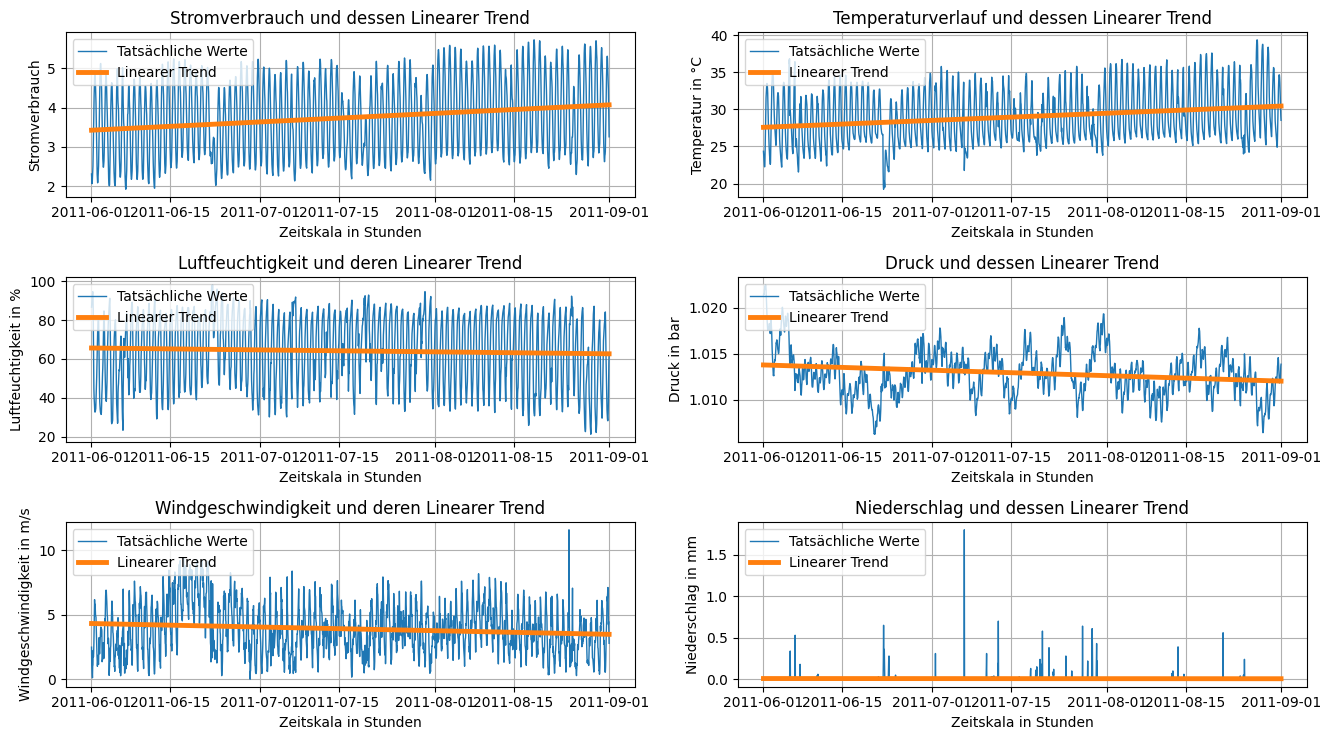

In [31]:
def plotLinTrend(dfCol, title, y_label, ax):
    #Plot acutal data and linear Regression
    ax.plot(dfCol, linewidth=1, label='Tatsächliche Werte')
    ax.plot(dfCol.index, linReg(dfCol), linewidth=3.5, label='Linearer Trend')

    #Adjust the plots
    ax.set_title(title)
    ax.set_xlabel('Zeitskala in Stunden')
    ax.set_ylabel(y_label)
    ax.legend(loc='upper left')
    ax.grid(True)

#Plot the figure
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13.5, 7.5))
axes = axes.flatten()

#Plot the data and trend line on each subplot
plotLinTrend(powerDF['TOTAL_LOAD'], 'Stromverbrauch und dessen Linearer Trend', 'Stromverbrauch', axes[0])
plotLinTrend(weatherDF['TEMPERATURE[C]'], 'Temperaturverlauf und dessen Linearer Trend', 'Temperatur in °C', axes[1])
plotLinTrend(weatherDF['HUMIDITY[%]'], 'Luftfeuchtigkeit und deren Linearer Trend', 'Luftfeuchtigkeit in %', axes[2])
plotLinTrend(weatherDF['PRESSURE[bar]'], 'Druck und dessen Linearer Trend', 'Druck in bar', axes[3])
plotLinTrend(weatherDF['WIND_SPEED[m/s]'], 'Windgeschwindigkeit und deren Linearer Trend', 'Windgeschwindigkeit in m/s', axes[4])
plotLinTrend(weatherDF['RAINFALL[mm]'], 'Niederschlag und dessen Linearer Trend', 'Niederschlag in mm', axes[5])

#Adjust layout
plt.tight_layout()
plt.show()

Beim Stromverbrauch und der Temperatur ist ein leicht positiver Trend zu erkennen.     
* Der steigende Temperaturtrend ist im betrachteten Zeitraum durchaus logisch, da die Temperatur in den Sommermonaten im Durchschnitt zunimmt.  
* Höhere Temperaturen führen häufig zu einem Anstieg des Stromverbrauchs, insbesondere in Regionen mit Klimaanlagen oder Kühlsystemem, was den steigenden Trend im Stromverbrauch erklären könnte.   

Bei Luftfeuchtigkeit, Druck und Windgeschwindigkeit sind leicht negative Trends zu sehen.  

* In den Sommermonaten kann die relative Luftfeuchtigkeit tendenziell abnehmen, insbesondere in heißen, trockenen Perioden. 
Steigende Temperaturen erhöhen die Verdunstungsrate, was zu einer niedrigeren relativen Luftfeuchtigkeit führt.
* Ein leichter Abfall im Luftdruck könnte durch die typische Wetterentwicklung im Sommer verursacht werden, da wärmere Temperaturen oft mit niedrigeren Drucksystemen verbunden sind, die zu stabilen, sonnigen Bedingungen führen.
* In den Sommermonaten sind oft ruhigere Wetterbedingungen vorherrschend, da starke Windsysteme und Stürme häufiger in anderen Jahreszeiten auftreten. Dies kann zu einem leichten Rückgang der durchschnittlichen Windgeschwindigkeit führen und den lecihten Trend erklären. Zudem stützt diese Verhätnismäßigkeit die Beobachtung des Luftdrucks.

Beim Niederschlag gibt es keinen Trend.  
* Der fehlende Trend beim Niederschlag deutet darauf hin, dass die Regenereignisse während des betrachteten Zeitraums zufällig verteilt sind und keine systematische Veränderung über die Zeit hinweg aufweisen.

Für einige Modelle könnte es hilfreich sein, die Lineare Regression mit zu übergeben, da so wichtige Strukturen unterstützt gelehrt werden. Wir fügen hierzu die der `'TOTAL_LOAD'` hinzu.  
Die `features` lassen wir erstmal unverändert und passen diese bei Bedarf an.

In [32]:
weather_powerDF['LINEAR_TREND'] = linReg(powerDF['TOTAL_LOAD'])

## 2.2 Periodizität
Da in den vorherigen Diagrammen der Datensätze zu Stromverbrauch, Temperatur, Luftfeuchtigkeit und Windgeschwindigkeit eine sich wiederholende Struktur zu erkennen ist, werden im Folgenden die Messwerte auf Periodizität untersucht.

Hierfür werden zunächst die Signale vom Trend bereinigt, wobei nur ein Zeitfenster von einigen aufeinanderfolgenden Tagen betrachtet wird, um genauere Beobachtungen zu ermöglichen. Die einzelnen Messwerte werden anschließend erneut geplottet. Zudem wird eine Autokorrelationsfunktion verwendet, um die genaue Periodendauer zu bestimmen.

In [33]:
#define df with detrended data
detrend_weather_powerDF = pd.DataFrame()

for column in weather_powerDF.columns:
    detrend_weather_powerDF[column] = weather_powerDF[column] - linReg(weather_powerDF[column])

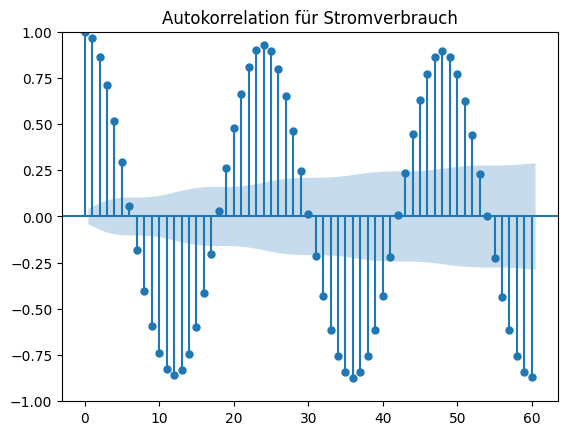

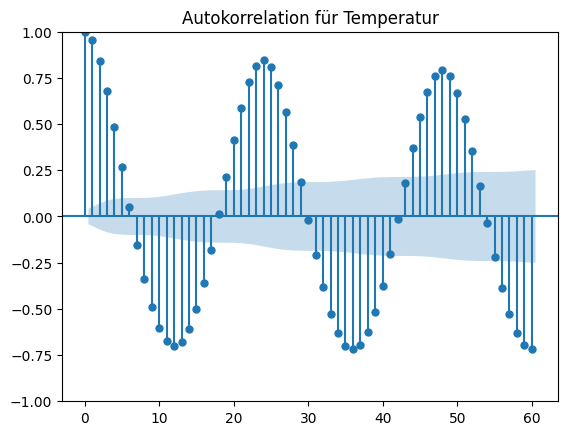

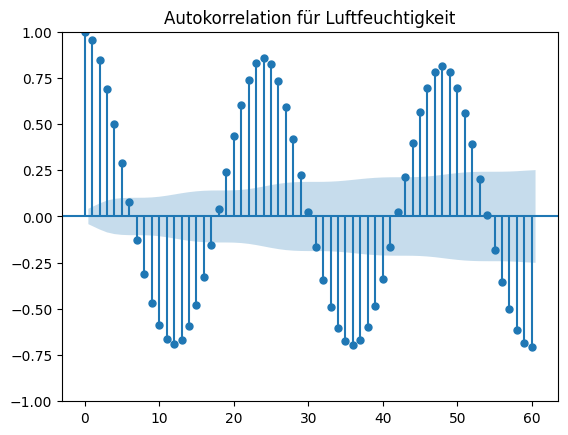

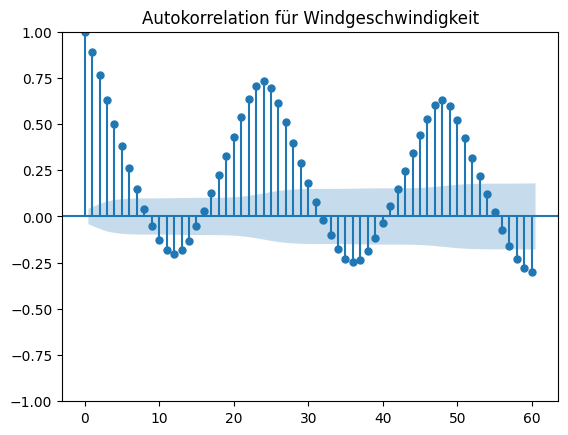

In [34]:
#acf plots
plot_acf(detrend_weather_powerDF['TOTAL_LOAD'], lags = 60, title = "Autokorrelation für Stromverbrauch");
plot_acf(detrend_weather_powerDF['TEMPERATURE[C]'], lags = 60, title = "Autokorrelation für Temperatur");
plot_acf(detrend_weather_powerDF['HUMIDITY[%]'], lags = 60, title = "Autokorrelation für Luftfeuchtigkeit");
plot_acf(detrend_weather_powerDF['WIND_SPEED[m/s]'], lags = 60, title = "Autokorrelation für Windgeschwindigkeit");

Aus den Plots für die Autokorrelation ist zu erkennen, dass alle vier Parameter eine Periodendauer von 24 Stunden haben.

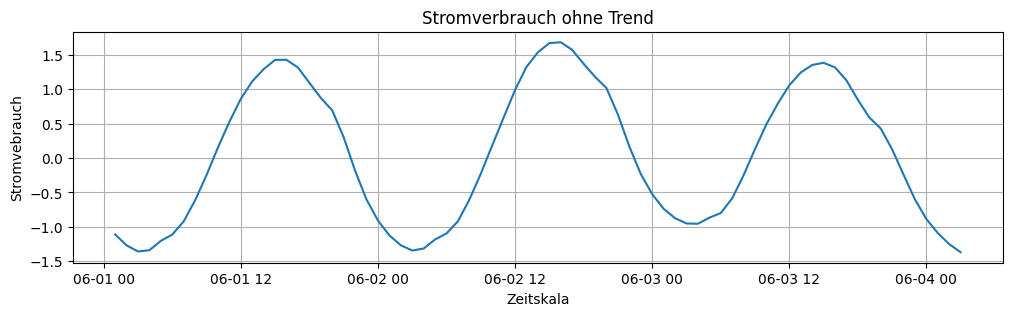

In [35]:
plotDF(detrend_weather_powerDF[0:75], 'TOTAL_LOAD', 'Stromverbrauch ohne Trend', 'Stromvebrauch')

Man erkennt im obigen Plot eindeutig eine Periodizität. Die Peaks haben in etwa einen zeitlichen Abstand von 24 Stunden, wobei diese sich im Bereich des frühen Nachmittags befinden. Diese Beobachtung lässt sich dadurch erklären, dass zu dieser Zeit am meisten Menschen wach sind und arbeiten/ produktiv sind und somit mit am meisten Strom verbrauchen. Nachts hingegen ist der Stromverbrauch am geringsten, da die Mehrheit der Menschen am schlafen ist und somit nicht viel Verbrauch zustande kommt. Dadurch erhält man eine Saisonalität im Sinne von Tag und Nacht, bzw. eine sich wiederholende Struktur alle 24 Stunden.

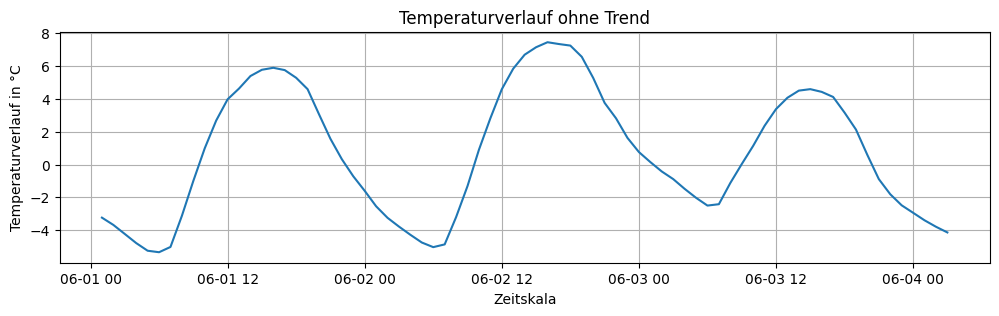

In [36]:
plotDF(detrend_weather_powerDF[0:75], 'TEMPERATURE[C]', 'Temperaturverlauf ohne Trend', 'Temperaturverlauf in °C')

Auch hier ist eine periodische Struktur zu erkennen. Die Peaks haben ebenfalls einen zeitlichen Abstand von 24 Stunden und befinden sich im Bereich des frühen Nachmittags. Dies lässt sich dadurch erklären, dass die Temperatur am Nachmittag den höchsten Wert erzielt und im Laufe des Tages abnimmt, bis sie in der Nacht ihr Tief hat, da logischerweise die Sonne nicht mehr scheint.

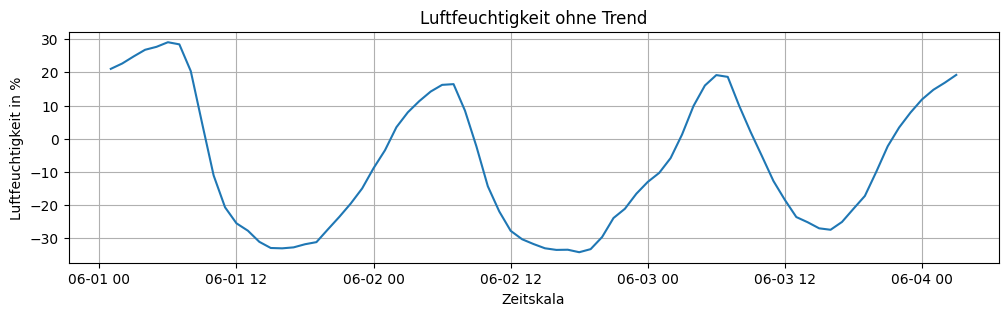

In [37]:
plotDF(detrend_weather_powerDF[0:75], 'HUMIDITY[%]', 'Luftfeuchtigkeit ohne Trend', 'Luftfeuchtigkeit in %')

Bei der Luftfeuchtigkeit ist eine zum Temperaturverlauf entgegengesetzte Periodizität zu erkennen, da die Peaks genau an den Stellen der Tiefs der Temperatur liegen. Dies liegt daran, dass bei niedriger Temperatur, die vor allem nachts vorliegt, auch die Luft abkühlt. Da kalte Luft weniger Wasser halten kann als warme Luft, steigt bei gleicher absoluter Menge an Feuchtigkeit die relative Luftfeuchtigkeit.

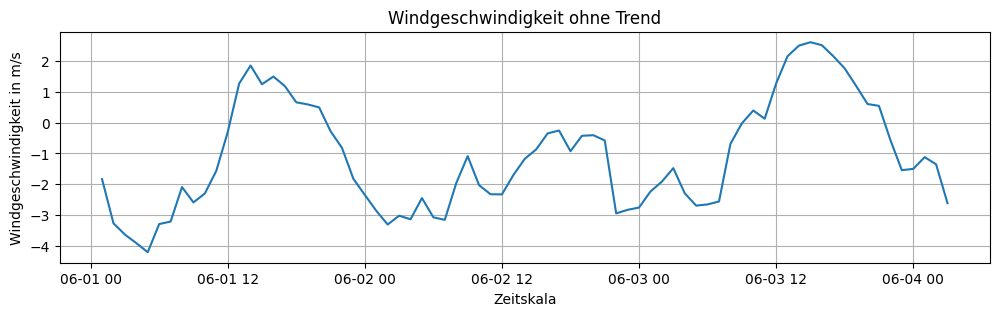

In [38]:
plotDF(detrend_weather_powerDF[0:75], 'WIND_SPEED[m/s]', 'Windgeschwindigkeit ohne Trend', 'Windgeschwindigkeit in m/s')

Bei der Windgeschwindigkeit ist eine leichte periodische Struktur zu erkennen, die sich der Temperatur anpasst. Die Abstände betragen ebenfalls 24 Stunden, wobei tagsüber mehr Wind ist als nachts. Diese Beobachtung lässt sich in der Meterologie damit erklären, dass die Windgeschwindigkeit eine starke positive Korrelation mit der Temperatur hat.

Nun sollen für einen besseren Vergleich alle 4 vorherigen Plots in einem Figure abgebildet werden.

<Figure size 1000x300 with 0 Axes>

Text(0.5, 1.0, 'Messwerte ohne Trend')

Text(0.5, 0, 'Zeitskala in Stunden')

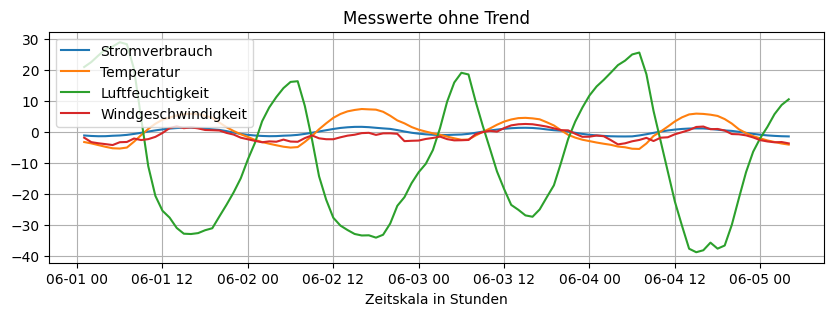

In [39]:
#Plot data withou trend
plt.figure(figsize=(10, 3))

plt.plot(detrend_weather_powerDF['TOTAL_LOAD'][0:100], label='Stromverbrauch')
plt.plot(detrend_weather_powerDF['TEMPERATURE[C]'][0:100], label='Temperatur')
plt.plot(detrend_weather_powerDF['HUMIDITY[%]'][0:100], label='Luftfeuchtigkeit')
plt.plot(detrend_weather_powerDF['WIND_SPEED[m/s]'][0:100], label='Windgeschwindigkeit')

#Adjust the plots
plt.title('Messwerte ohne Trend')
plt.xlabel('Zeitskala in Stunden')
plt.grid(True)
plt.legend(loc='upper left')

Hier ist nochmal schön zu sehen, dass die Daten zum Stromverbrauch, zur Temperatur und zur Windgeschwindigkeit die gleiche Form von Periodizität haben bzw. synchron zueinander verlaufen. Die Werte zur Luftfeuchtigkeit hingegen sind genau asynchron zum Rest. 

## 2.3 Korrelation 

In diesem Unterkapitel wird untersucht ob und welche Art von Korrelation zwischen den einzelnen Parametern besteht.  
Hierfür werden zunächst eine Korrelationsmatrix sowie ein Pairplot erstellt, um einen Gesamtüberblick zu erhalten.

<Axes: >

Text(0.5, 1.0, 'Korrelationsmatrix der Wetter- und Stromdaten')

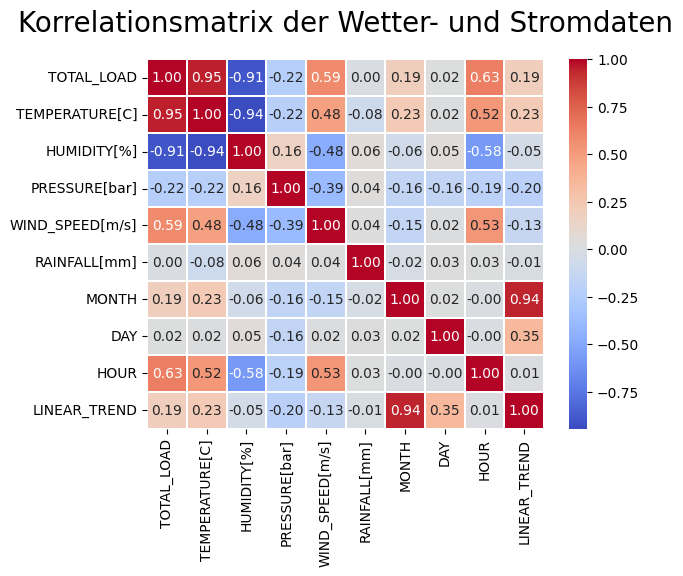

In [40]:
#generate the correlation matrix
corrMatrix = weather_powerDF.corr()

#Plot the corr Matrix
sns.heatmap(corrMatrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.2)
plt.title('Korrelationsmatrix der Wetter- und Stromdaten', size=20, pad = 20)
plt.show()

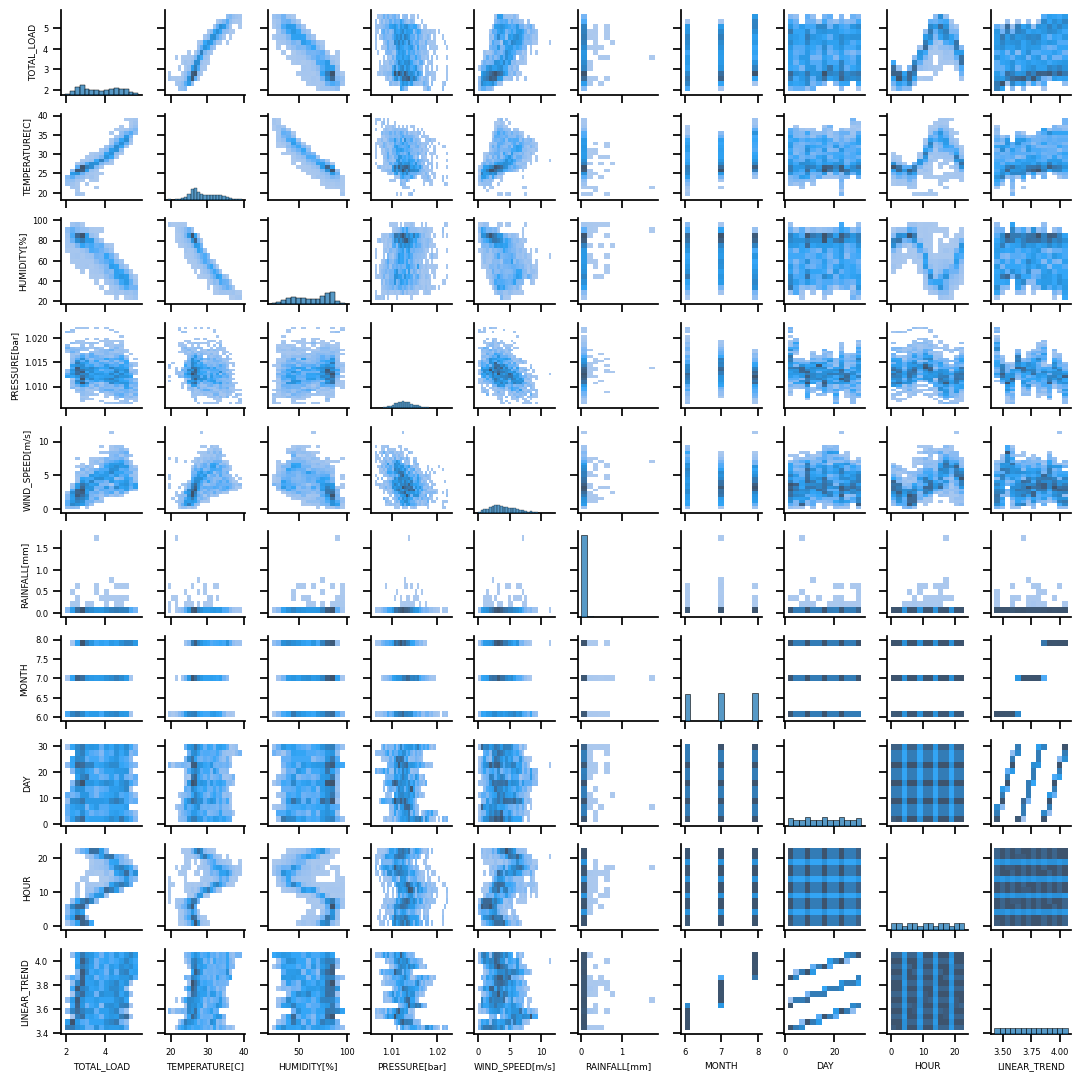

In [41]:
#Define settings for the pairplot
sns.set_context("notebook", rc={"axes.labelsize": 6.5, "xtick.labelsize": 6, "ytick.labelsize": 6})

sns.pairplot(weather_powerDF, height=1.1, kind="hist")

Aus der Korrelationsmatrix sowie dem Pairplot erkennt man eine stark positive Korrelation zwischen Temperatur und Stromverbrauch, da der Korrelationskoeffizient einen Wert von 0,95 annimmt. Dies lässt sich darauf zurückführen, dass tagsüber eine höhere Temperatur vorliegt als nachts und gleichzeitig am Tag mehr Menschen wach sind, die Strom verbrauchen. Somit entsteht indirekt eine positive Korrelation zwischen Temperatur und Stromverbrauch aufgrund der Tag-Nacht-Saisonalität.

Da, wie bereits zuvor beobachtet, zwischen Temperatur und Luftfeuchtigkeit eine negative Korrelation von -0,91 besteht, sind auch die Parameter Luftfeuchtigkeit und Stromverbrauch negativ miteinander korreliert.

Die Windgeschwindigkeit zeigt ebenfalls eine positive Korrelation mit dem Stromverbrauch, mit einem Korrelationskoeffizienten von 0,59, was ebenfalls durch die Abhängigkeit von der Temperatur erklärbar ist.

## 2.4 Ausreißer 

Nun sollen unter den Datensätzen die auffälligen Ausreißer im Zeitraum zwischen dem 15.06. und 01.07.2011 sowie zwischen dem 15.07. und 01.08.2011 untersucht werden. Zunächst wird mithilfe des Medians das genaue Datum der Ausreißer ermittelt, wobei der bereits definierte Dataframe `powerDF_daily` verwendet wird, da hierfür nur die Tageswerte relevant sind und eine Saisonalität von 24 Stunden vorliegt.

Als Ausreißer wird in unserem Fall ein täglicher Stromverbrauch bewertet, der mehr als 15 MWh vom Median abweicht.

In [42]:
#calculate median of powerDF_daily
med = st.median(powerDF_daily['TOTAL_LOAD'])

#show outliers
powerDF_daily[(powerDF_daily['TOTAL_LOAD'] < med-15) | (powerDF_daily['TOTAL_LOAD'] > med+15)]

TOTAL_LOAD  HOUR  MONTH  DAY
#DATE                                                  
2011-06-22 00:00:00+00:00      68.692   276    144  528
2011-07-19 00:00:00+00:00      73.999   276    168  456

Aus der obigen Tabelle lässt sich ablesen, dass es am 22.06. und am 19.07. größere Ausreißer im Stromverbrauch gegeben hat. Am 22.06. weicht der Wert sogar über 20 MWh vom Median sowie vom Mittelwert ab.  

Nachfolgend wird der erste Ausreißer in den Datensätzen für Stromverbrauch, Temperatur, Luftfeuchtigkeit und Windgeschwindigkeit geplottet.

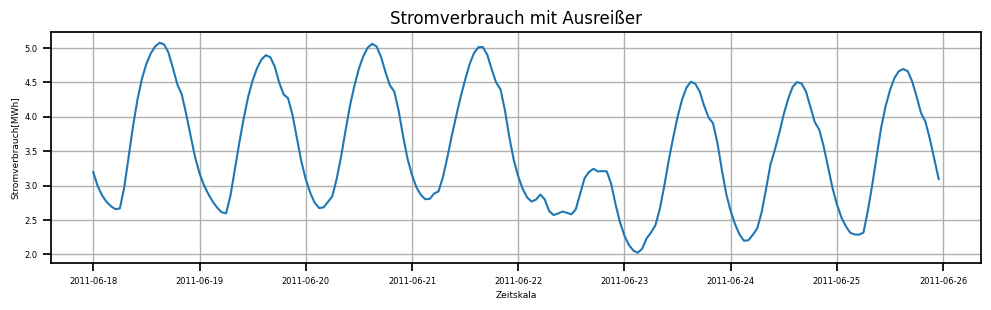

In [43]:
#Plot period with outlier in powerDF
plotDF(powerDF['2011-06-18':'2011-06-25'], 'TOTAL_LOAD', 'Stromverbrauch mit Ausreißer', 'Stromverbrauch[MWh]')

Es ist deutlich zu erkennen, dass es am 22.06. einen Einbruch im Stromverbrauch gab. Da es am 20.06.2011 und an den darauf folgenden Tagen in Teilen der USA Tornado-Ausbrüche gegeben hat, wird vermutlich auch San Francisco in abgeschwächter Form davon betroffen gewesen sein.  
Eine mögliche Auswirkung könnte ein Stromausfall gewesen sein, wodurch sich der Ausreißer erklären ließe. (siehe https://data.usatoday.com/tornado-archive/kansas/328691/ und https://en.wikipedia.org/wiki/Tornado_outbreak_of_June_18%E2%80%9322,_2011 und https://www.weather.gov/lmk/june22_2011).

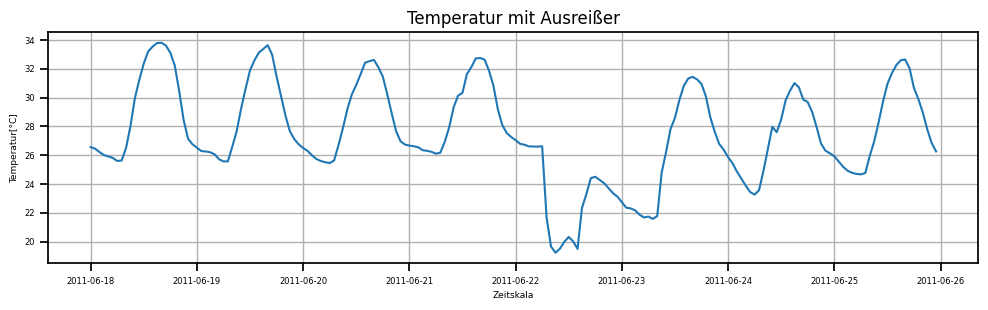

In [44]:
#Plot period with outlier in temperature
plotDF(weatherDF['2011-06-18':'2011-06-25'], 'TEMPERATURE[C]', 'Temperatur mit Ausreißer', 'Temperatur[°C]')

Auch beim Temperaturverlauf ist am 22.06. ein Ausreißer zu beobachten, was mit der Theorie von vorhin Sinn ergeben würde, da es durch mögliche Unwetter einen Temperatursturz gab.

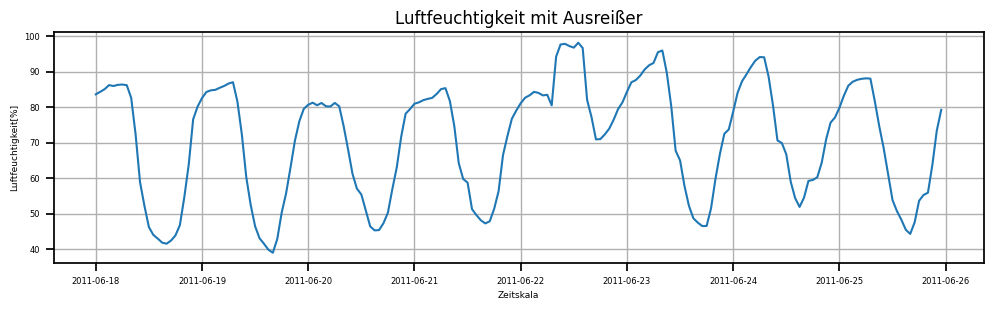

In [45]:
#Plot period with outlier in humidity
plotDF(weatherDF['2011-06-18':'2011-06-25'], 'HUMIDITY[%]', 'Luftfeuchtigkeit mit Ausreißer', 'Luftfeuchtigkeit[%]')

Wie bei den vorherigen zwei Datensätzen ist auch hier am 22.06. ein Ausreißer zu sehen. Dies wäre unter Annahme der angesprochenen Theorie dadurch zu erklären, dass aufgrund der in diesem Zeitraum stark abgesenkten Lufttemperatur die Luftfeuchtigkeit zugenommen hat.

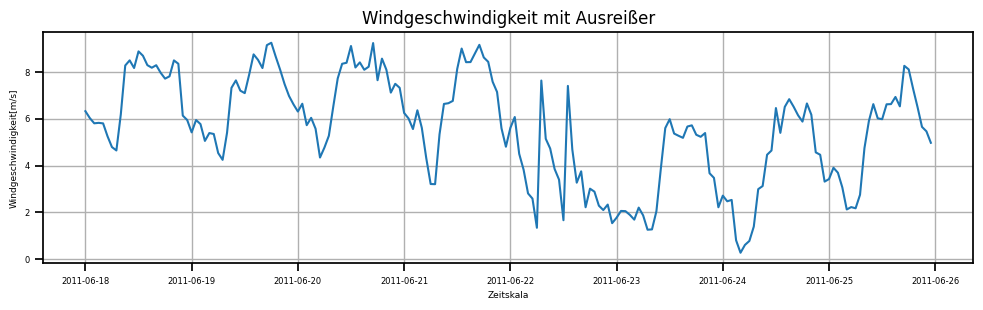

In [46]:
#Plot period with outlier in wind speed
plotDF(weatherDF['2011-06-18':'2011-06-25'], 'WIND_SPEED[m/s]', 'Windgeschwindigkeit mit Ausreißer', 'Windgeschwindigkeit[m/s]')

Bei der Windgeschwindigkeit ist am 22.06. auffällig, dass zwei klare Peaks zu erkennen sind, welche auf ein unbeständiges Wetter an diesem Tag zurückgeführt werden könnten. Auch diese Erkenntnis passt zu der These, dass Unwetter Ursache für den niedrigen Stromverbrauch sind.

Da wir zum zweiten Ausreißer am 19.07. keine möglichen Ursachen gefunden haben, wird dieser nicht weiter untersucht.  

Wir können aber für die späteren Modelle mitnehmen, dass wir durchaus Tage in dem Datensatz haben, die von der Norm abweichen. Diese könnten eventuell schlechter prognostizierbar sein, da für diese nicht in der selben Anzahl Daten vorliegen und auch die beobachteten Strukturen nicht mehr zutreffen.

# 3. Vorbereitung für die Prognosemodelle
Wir kommen langsam der eigentlichen Aufgabenstellung näher. Allerdings wollen wir noch einige Vorbereitungen treffen, die für so gut wie alle Modelle relevant sind.

## 3.1 Anpassung der Targets
Jetzt passen wir die Datensätze so an, dass wir die Werte der Stromverbrauchs um 1h bzw 24H nach vorne ziehen und somit eine entsprechende versetzte Zurodnung zu den Wetterdaten erzeugen.  
So wird gewährleistet, dass die Modelle zu den aktuellen Wetterdaten die zukünftigen Stromverbrauchsdaten als Referenz besitzen und darauf trainiert werden, Prognosen zu erstellen und nicht nur den aktuellen Verbrauch einzuschätzen.

In [47]:
#Add new columns to the targets list
targets += ['TOTAL_LOAD_1H', 'TOTAL_LOAD_24H']

#Add target to the general df
weather_powerDF[targets[0]] = pd.DataFrame(weather_powerDF.loc[:, 'TOTAL_LOAD'].shift(-1))
weather_powerDF[targets[1]] = pd.DataFrame(weather_powerDF.loc[:, 'TOTAL_LOAD'].shift(-24))

## 3.2 Train-Test Split
Da unser Datensatz nur drei Monate eines Jahres beinhaltet, benutzen wir einfachheitshalber die ersten 80% der Daten als unsere Trainingsdaten und die restlichen 20% als Testdaten.  
Wir wollen unserern Datensatz in Trainingsdaten und Testdaten unterteilen. Dazu wählen wir je die `features` und `targets` Spalten.  
Dabei sollen die Features frei wählbar sein, um nach Bedarf für das Modell andere Features in den Daten auswählen zu können.

Wir benutzen nicht die vordefnierte Funktion, da wir in jedem Split zeitgleich `y_1H_` und `y_24H_` erhalten wollen, `X_` allerdings nur einmal.  
Dies ist allerdings nur Geschmackssache.

In [48]:
def train_test_split(df, features):
    #Position of the row next to 80% of the data
    index80percent = round(len(df)*0.8)
    
    #Separate into Train and Test df
    df_train = df[:index80percent]
    df_test = df[index80percent:]
    
    #Train and Test Dataset for the Features
    X_train = df_train[features]
    X_test = df_test[features]
    
    #Train and Test Dataset for the Targets 1H and 24H ahead
    y_1H_train = df_train[targets[0]]
    y_1H_test = df_test[targets[0]]
    y_24H_train = df_train[targets[1]]
    y_24H_test = df_test[targets[1]]
    
    return X_train, X_test, y_1H_train, y_1H_test, y_24H_train, y_24H_test

In [49]:
X_train, X_test, y_1H_train, y_1H_test, y_24H_train, y_24H_test = train_test_split(weather_powerDF, features)

## 3.3 Funktionen für Modellanalyse und Vergleich 
Um später das Prognosemodell bewerten zu können und auch die verschiedenen Modelle effetkiv miteinander vergleichen zu können ist es sinnvoll stets dafür geeignete Metriken und Grafiken zu generieren.  
Dazu definieren wir Funtkionen, um diesen Prozess zu vereinheitlichen und Duplikate zu vermeiden.  
Auch für häufig verwendete Abläufe wollen wir Funktionen definieren.

### 3.3.1 Allgemeine Funktionen 
In allen Modellen wollen wir die Vorhersagen mit den tatsächlichen Werten vergleichen.  
Dazu wollen wir die Daten in einem DF bündeln und optional einen Titel übergeben, der den DF beschreibt.

In [50]:
def createPredObservDF(actual_data, pred_data, title):
    df = pd.DataFrame({'Observations': actual_data, 'Predictions': pred_data})

    #Access to the df title with df.attrs['title']
    df.attrs['title'] = title

    return df

Für einige Modelle ist zunächst eine Skalierung der Daten notwendig.  Da dies für mehrere Modelle in Frage kommt, erstellen wir hierfür ebenfalls ein Funktion.   
Es können stehts formähnliche Dataframes übergeben werden, die dann nacheinander transformiert werden.  
Zudem kann die Skalierart übergeben werden, die als Standard auf den `MinMaxScaler` gesetzt wurde.

In [51]:
def scale(dfList, scaler = MinMaxScaler()):
    #Loop through all df in dfList in order to scale
    
    for i in range(len(dfList)):
        #Check dimension of df and if needed reshape
        reshape = False
        if dfList[i].ndim == 1:
            dfList[i] = dfList[i].values.reshape(-1, 1)
            reshape = True

        #Transform df
        if i == 0:
            dfList[i] = scaler.fit_transform(dfList[i])
        else:
            dfList[i] = scaler.transform(dfList[i])
        
        #Shape back if needed
        if reshape:
            dfList[i] = dfList[i].ravel()
            
    return dfList

### 3.3.2 Funktionen für die Modellanalyse
Auch die Bewertung der Modelle ist stets relevant. Dazu werden verschiedene Metriken verwendet, die diesen Prozess greifbarer machen.  
Wir haben uns auf die Folgenden festgelegt:

* Mean Absolute Error (`mae`) - Misst den durchschnittlich absoluten Unterschied zwischen den vorhergesagten und den tatsächlichen Werten.  
Diese Metrik gibt einen intuitiven Eindruck von der Größe der Fehler.

* Mean Squared Error (`mse`) - Misst den durchschnittlich quadrierten Fehler. Diese Metrik betont größere Fehler stärker, da Fehler quadriert werden.

* Root Mean Squared Error (`rmse`) - Misst die Quadratwurzel des mittleren quadratischen Fehlers. RMSE bringt die Metrik zurück in die ursprünglichen Einheiten und gibt eine Vorstellung von der Größe der Fehler. Es ist besonders nützlich, wenn größere Fehler problematischer sind.

* R2-Score (`r2`) - Misst den Anteil der Varianz in den tatsächlichen Werten, der durch das Modell erklärt wird. Ein R2-Score von 1 bedeutet, dass das Modell perfekt ist, während ein Wert von 0 darauf hinweist, dass das Modell die Varianz der Daten nicht besser erklärt als der Mittelwert.

* Korrelation (`corr`) - Misst die Stärke und Richtung der linearen Beziehung zwischen den vorhergesagten und den tatsächlichen Werten.

* Bias (`bias`) - Misst die systematische Abweichung der Vorhersagen von den tatsächlichen Werten. Ein hoher Bias kann darauf hinweisen, dass das Modell konsistent zu hohe oder zu niedrige Vorhersagen macht.

Diese können bei Übergabe der Ergebnisse erstellt werden. 

In [52]:
def modelMetrics(train_results, test_results):
    #Generate DF to store the metrics
    metricDF = pd.DataFrame(columns=['Train Data', 'Test Data'], index=['mae', 'mse', 'rmse', 'r2', 'corr', 'bias'])

    for column, df in zip(metricDF.columns, [train_results, test_results]):
        #Drop possible NaN values from df (Could occur when future data is predicted without actual target data)
        df = df.dropna()

        #Compute relevant metrics for model analysis and comparison
        mae = mean_absolute_error(df.iloc[:, 0], df.iloc[:, 1])
        mse = mean_squared_error(df.iloc[:, 0], df.iloc[:, 1])
        rmse = np.sqrt(mse)
        r2 = r2_score(df.iloc[:, 0], df.iloc[:, 1])
        corr = np.corrcoef(df.iloc[:, 0], df.iloc[:, 1])[0, 1]
        bias = np.mean(df.iloc[:, 1]) - np.mean(df.iloc[:, 0])

        #Add metrics to the DF in the corresponding column
        metricDF.loc[:, column] = [mae, mse, rmse, r2, corr, bias]

    return metricDF.T

### 3.3.3 Funktionen für Grafiken
Eine Visualiserug der Ergebnisse ist eine gut Möglichkeit, um schnell sich einen Eindruck verschaffen uz können, ohne genaue Zahlenwerte untersuchen zu müssen.  
  
Dazu erstellen wir zunächst einen Plot der für die Trainings- und Testdaten die tatsächlichen und vorhergesagten Werte gegenüberstellt.

In [53]:
def plot_results(train_results, test_results, title):
    #Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 6))

    #plot train and test separate in subplots
    for ax, df in zip((ax1, ax2), (train_results, test_results)):
        #Plot the data
        ax.plot(df['Predictions'], label='Predicted')
        ax.plot(df['Observations'], label='Observations')

        #Highlight Predictions in ax2 where Observations are missing
        if df['Observations'].isna().any():
            missing_indices = df.index[df['Observations'].isna()]
            ax.plot(df.loc[missing_indices, 'Predictions'], label='Predicted (No Observations)', color='tab:red', linewidth=2, marker ='o')

            handles, labels = ax2.get_legend_handles_labels()
            ax2.legend(handles=handles, labels=labels, loc='upper right')

        #Adjust the subplots
        ax.set_title(df.attrs.get('title'))
        ax.set_xlabel('Zeitskala')
        ax.set_ylabel('Stromverbrauch')
        ax.legend(loc='upper left')
        ax.grid(True)

    #Adjust the general plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle(title)

    plt.show()

# 4. Multivariates Lineares Modell 
Nun widmen wir uns der Aufgabenstellung den Stromverbrauch für je 1h oder 24h nach vorne vorherzusagen.  
Dazu soll zunächst ein Multivairates Lineares Modell erstellt werden.  
  
Im ersten Schritt müssen wir noch eine zusätzliche Spalte dem X-Datensatz hinzufügen, um die Konstante b_0 im Model zu simulieren.

In [54]:
#Add a 1-column to the model (for constant b_0 in model)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test, has_constant='add')

Wir defnieren einen festen Ablauf für das Modell, um mehrere Modelle standardisiert auszuprobieren.

In [55]:
#Give the X and Y values of the Train and Test data in order to run the Multivariat Regression Model
#If you want a summary of the fitted Model, use the bool summary

def run_MVModel(X_train, y_train, X_test, y_test, summary = True):
    #Initialize and Fit the OLS model
    MV_model = sm.OLS(y_train, X_train)
    MV_model_fit = MV_model.fit()

    #Print the model summary
    if summary:
        print(MV_model_fit.summary())

    #Predict y values
    y_train_pred = MV_model_fit.predict(X_train)
    y_test_pred = MV_model_fit.predict(X_test)

    #Create dataframes with actual and predicted values
    train_results =  createPredObservDF(y_train, y_train_pred, 'Train Data')
    test_results = createPredObservDF(y_test, y_test_pred, 'Test Data')
    
    return train_results, test_results


## 4.1 Prediction - 1H
Zunächst betrachten wir die Performance des Models für die 1H Predicition.

In [56]:
train_results, test_results = run_MVModel(X_train, y_1H_train, X_test, y_1H_test)

                            OLS Regression Results                            
Dep. Variable:          TOTAL_LOAD_1H   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     5710.
Date:                Sun, 30 Jun 2024   Prob (F-statistic):               0.00
Time:                        11:26:15   Log-Likelihood:                 598.83
No. Observations:                1766   AIC:                            -1178.
Df Residuals:                    1756   BIC:                            -1123.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -17.9120      1.977     

Das gefittete multivariate lineare Modell zeigt schon mal vielversprechende Ergebnisse. 
* Der `R-squared` von 0.896 bedeutet, dass etwa 89.6% der Varianz in der abhängigen Variable (`TOTAL_LOAD_24H`) durch die unabhängigen Variablen im Modell erklärt wird.  
Dies ist ein sehr hoher Wert und deutet darauf hin, dass das Modell gut an die Daten angepasst ist.
* Der sehr hohe `F-statistic` Wert von 5710 und der extrem niedriger p-Wert (`Prob (F-statistic)`) (praktisch 0) zeigen, dass das Modell insgesamt statistisch signifikant ist  
und die unabhängigen Variablen gemeinsam einen signifikanten Einfluss auf die abhängige Variable haben.

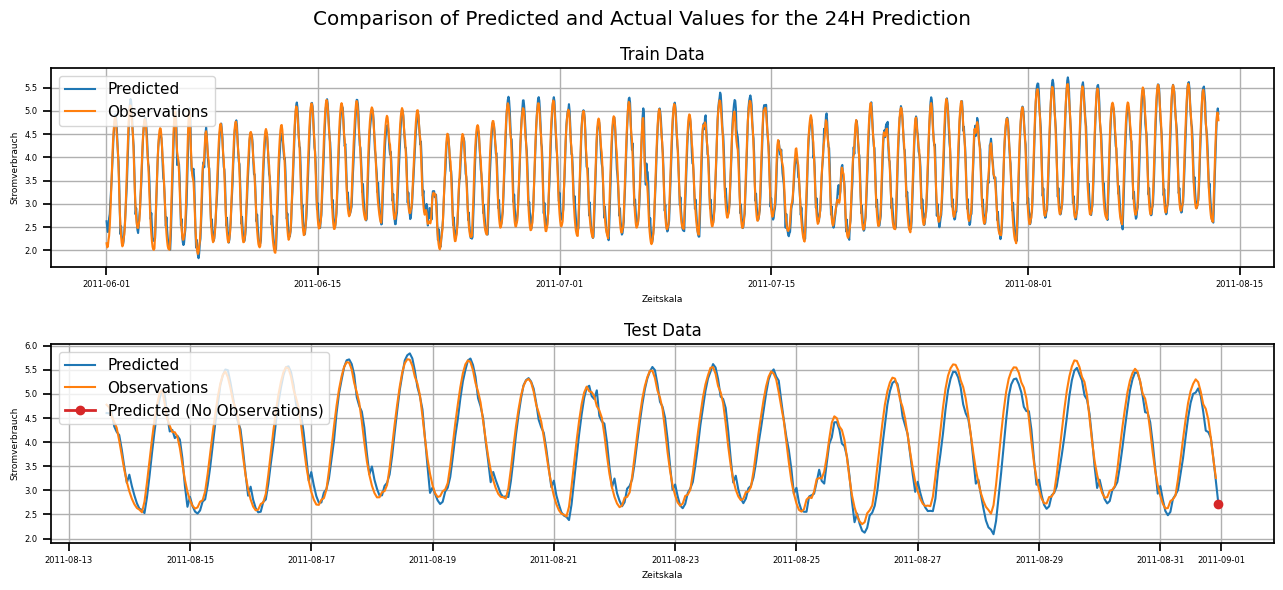

mae       mse      rmse        r2      corr      bias
Train Data  0.139094  0.029716  0.172385  0.966962  0.983342       0.0
Test Data   0.163059  0.044153  0.210125  0.956749  0.980907 -0.073474

In [57]:
plot_results(train_results, test_results, 'Comparison of Predicted and Actual Values for the 24H Prediction')
modelMetrics(train_results, test_results)

Die Prognose des multivariaten linearen Modells sieht auf den ersten Blick vielversprechend aus. Schauen wir uns die einzelnen Metriken genauer an, um eine fundierte Bewertung vornehmen zu können.  
 
Der `mae` beträgt 0.139 für die Trainings und 0.163 für die Testdaten. Diese Werte sind relativ gering. Diese Metrik zeigt, dass die durchschnittlichen Abweichungen des Modells von den tatsächlichen Werten gering sind.  
Der `rmse` ist mit 0.172 und 0.210 etwas höher, allerdings liegt dieser Unterschied im akzeptablen Bereich. Der höhere `rmse` im Vergleich zum `mae` deutet darauf hin, dass es einige stärkere Abweichungen gibt, diese jedoch nicht dominieren.  
Mit einem `r2` von 0.983 und 0.980 zeigt das Modell eine hervorragende Anpassungsfähigkeit und ist sehr gut in der Lage, die Daten zu erklären.
  
Allerdings haben wir bei den Testdaten einen leicht negativen Bias. Somit wird nachfolgend überlegt, durch welche Methoden eine Optimierung möglich sei.

Mögliche Ideen für eine Verbesserung des Modells wären:
* Daten vom Vortag für Prognose verwenden, um Ausreißer auszugleichen 
* Hinzufügen des Linearen Trends (lineare Regressionsgerade von `TOTAL_LOAD`)
* Höhere Wertung der Stunden und der Temperatur (Stunden, da diese wichtig sind als Grundlage für die Periodizität; Temperatur, da im 3. Kapitel die starke positive Korrelation mit dem Stromverbrauch festgestellt worden ist)

Nachfolgend ist eine Tabelle mit den Referenz-Werten `mae`, `r2` und `bias` dargestellt. Sie beinhaltet Ergebnisse für die Test-Daten des Modells mit den Feauters Linearer Trend, quadrierte Temperatur, quadrierte Stunden und um 24 Stunden nach vorne geshifteter Stromverbrauch. Zudem werden noch zwei Kombinationen aus den 4 Features abgebildet. Es ist zu erkennen, dass sich durch den Linearen Trend die Werte tendenziell verschlechtern. Durch die Zugabe der Features quadrierte Temperatur und geshifteter Stromverbrauch wird das Modell etwas verbesert. Allerdings ist durch das Feature quadrierte Stunden eine deutliche Verbesserung des Modells zu beobachten. Die Kombination aus geshiftetem Stromverbrauch und quadrierten Stunden bewirkt die beste Optimierung mit einem mittleren absoluten Fehler von 0.101, einem r2-Score von 0.985 und einem Bias von -0.0251.

  Aus Übersichtlichkeitsgründen wird im Anschluss der Tabelle nur der Code zu der besten Kombination abgebildet. 

|   |mae|r2 |bias|
|:--|:--|:--|:---|
|Original Model|0.163|0.957|-0.0735|
|Model with linear trend|0.169|0.954|-0.0928|
|Model with squared hours|0.102|0.984|-0.0283|
|Model with squared temperature|0.162|0.959|-0.0648|
|Model with shifted total load|0.158|0.961|-0.0531|
|Model with shifted total load, squared hours and squared temperature|0.11|0.982|-0.0402|
|Model with shifted total load and squared hours|0.101|0.985|-0.0251|

mae       mse      rmse        r2      corr      bias
Train Data  0.084833  0.011426  0.106894  0.987296  0.993628  0.000039
Test Data   0.101167  0.015702  0.125307  0.984619  0.992685 -0.025106

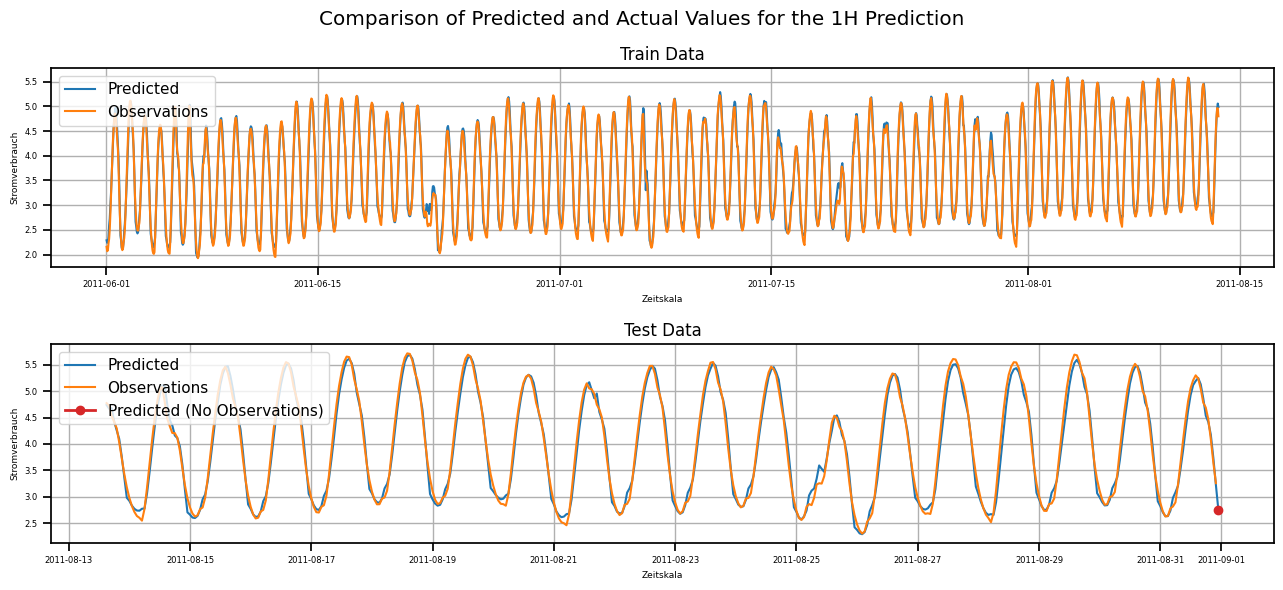

In [68]:
#Shift the total load column by 24 time steps
weather_powerDF['TOTAL_LOAD_1d'] = weather_powerDF['TOTAL_LOAD'].shift(24).fillna(0)

#Add column with squared temperature
weather_powerDF['HOUR_SQ'] = weather_powerDF['HOUR']**2


#Redefine train and test set with added feature
features1MVL = features + ['TOTAL_LOAD_1d'] + ['HOUR_SQ'] 
X_train, X_test, y_1H_train, y_1H_test, y_24H_train, y_24H_test = train_test_split(weather_powerDF, features1MVL)

#Run new Model 
train_results, test_results = run_MVModel(X_train, y_1H_train, X_test, y_1H_test, False)

modelMetrics(train_results, test_results)

plot_results(train_results, test_results, 'Comparison of Predicted and Actual Values for the 1H Prediction')

## 4.2 Prediction - 24H

                            OLS Regression Results                            
Dep. Variable:         TOTAL_LOAD_24H   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     1678.
Date:                Fri, 28 Jun 2024   Prob (F-statistic):               0.00
Time:                        10:45:46   Log-Likelihood:                -411.24
No. Observations:                1766   AIC:                             842.5
Df Residuals:                    1756   BIC:                             897.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -10.0807      3.502     

mae       mse      rmse        r2      corr      bias
Train Data  0.202766  0.093281  0.305419  0.895856  0.946497      -0.0
Test Data   0.214515  0.094664  0.307675  0.908399  0.956767  0.077152

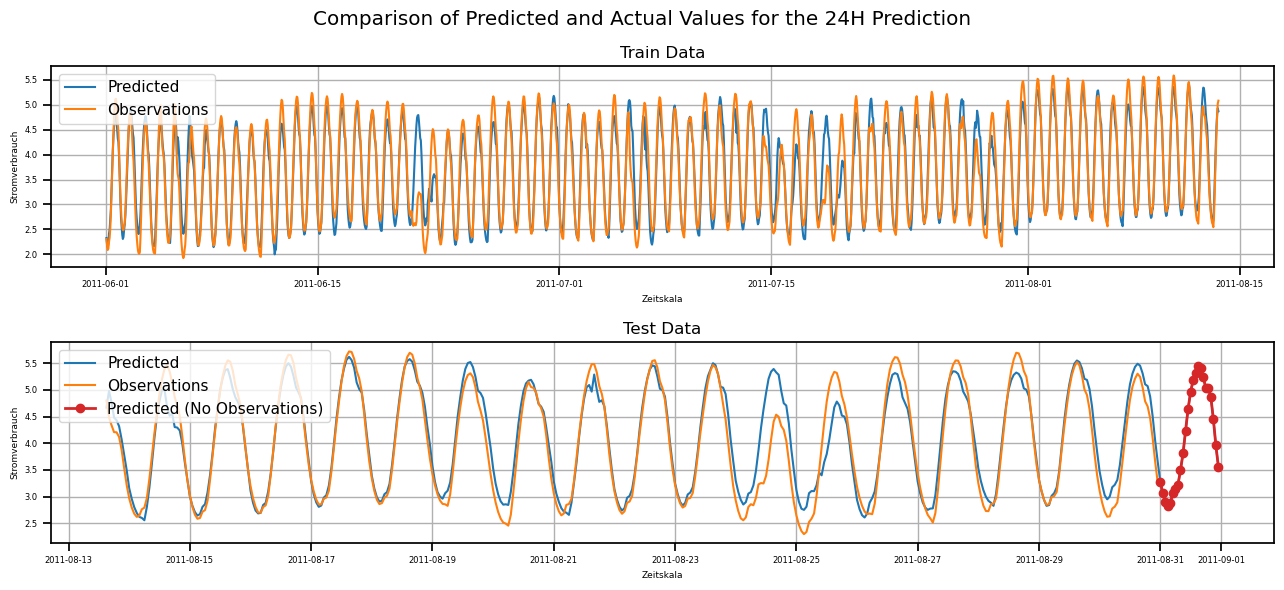

In [60]:
train_results, test_results = run_MVModel(X_train, y_24H_train, X_test, y_24H_test)
modelMetrics(train_results, test_results)
plot_results(train_results, test_results, 'Comparison of Predicted and Actual Values for the 24H Prediction')

Die Prognose des multivariaten Modells sieht auch für die 24h-Prediction bis auf einzelne Ausreißer sehr vielversprechend aus. Vor allem zwischen 24.08. und 26.08. sind größere Abweichungen zu erkennen. Nun sollen ebenfalls die einzelnen Metriken untersucht werden, um eine gezieltere Aussage zu dem Modell treffen zu können.

  Der `mae` beträgt bei den Trainings 0.203 und bei den Testdaten 0.215. Die Werte entsprechen einem relativ kleinen Fehler, die jedoch Verbesserungspotential haben.
  
  Der `rmse` ist mit 0.305 bzw. 0.308 ziemlich hoch, was auf die stärkeren Abweichungen zurückzuführen ist.

  Der `r2` beträgt 0.9 bzw. 0.908, was ziemlich gut ist und einer durchaus passablen Anpassungsfähigkeit des Modells entspricht.

  Da es durchaus Verbesserungspotential gibt, werden im Folgenden die gleichen Änderungen am Modell vorgenommen wie in 4.1, um eine mögliche Optimierung zu erhalten.

Nachfolgend ist eine Tabelle mit den Referenz-Werten `mae`, `r2` und `bias` dargestellt. Sie beinhaltet Ergebnisse für die Test-Daten des Modells mit den Feauters Linearer Trend, quadrierte Temperatur, quadrierte Stunden und um 24 Stunden nach vorne geshifteter Stromverbrauch. Zudem werden noch zwei Kombinationen aus den 4 Features abgebildet, welche von allen ausprobierten Kombinationsmöglichkeiten die besten Werte enthielten. Es ist zu erkennen, dass der Lineare Trend alleine eine leichte Optimierung hervorruft und die anderen 3 Features tendenziell sogar eine Verschlechterung des Modells darstellen. Die Kombination aus allen 4 Features bewirkt eine Verbesserung des durschnittlichen absoluten Fehlers und des r2-Scores, jedoch eine Verschlechterung des Bias-Werts. Als beste Optimierung hat sich die Kombination aus den Features quadrierte Stunden, Linearer Trend und geshifteter Stromverbrauch herausgestellt, bei der sich alle 3 Werte verbessert haben und die Gesamtverbesserung des Modells am besten ist. Der `mae` liegt nun bei 0.199, der r2-Score bei 0.915 und der Bias-Wert bei 0.0737. Allerdings ist leider festzustellen, dass keine der Kombinationen eine enorme Verbesserung des Modells hervorruft. 

  Aus Übersichtlichkeitsgründen wird im Anschluss der Tabelle nur der Code zu der besten Kombination abgebildet. 

|   |mae|r2 |bias|
|:--|:--|:--|:---|
|Original Model|0.215|0.908|0.0772|
|Model with linear trend|0.213|0.909|0.072|
|Model with squared hours|0.222|0.906|0.093|
|Model with squared temperature|0.212|0.906|0.107|
|Model with shifted total load|0.219|0.907|0.0817|
|Model with shifted total load, linear trend and squared temperature|0.199|0.915|0.0737|
|Model with all new features|0.201|0.915|0.0816|

mae       mse      rmse        r2      corr      bias
Train Data  0.201333  0.090633  0.301052  0.898813  0.948057  0.000014
Test Data   0.199196  0.087757  0.296239  0.915082  0.959398   0.07368

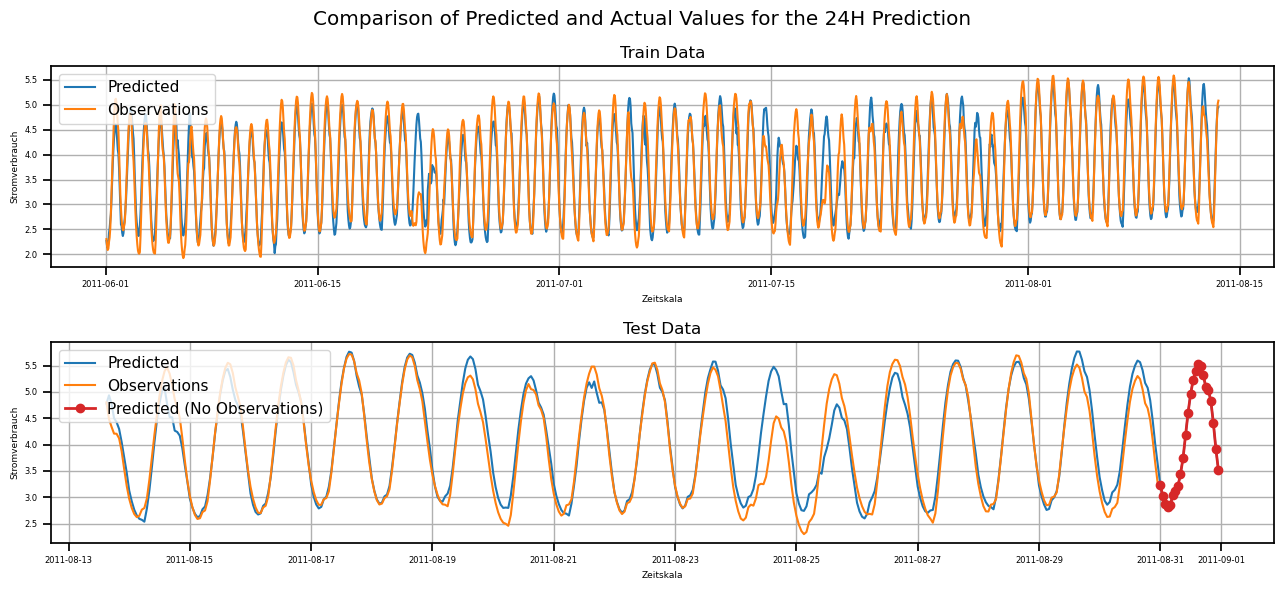

In [61]:
#Redefine train and test set with added feature linear trend
features24MVL = features + ['LINEAR_TREND']

#Shift the total load column by 24 time steps
weather_powerDF['TOTAL_LOAD_1d'] = weather_powerDF['TOTAL_LOAD'].shift(24).fillna(0)

#Add column with squared temperature
weather_powerDF['TEMPERATURE_SQ'] = weather_powerDF['TEMPERATURE[C]']**2

#Redefine train and test set with added feature
features24MVL = features + ['TEMPERATURE_SQ'] + ['LINEAR_TREND'] + ['TOTAL_LOAD_1d']
X_train, X_test, y_1H_train, y_1H_test, y_24H_train, y_24H_test = train_test_split(weather_powerDF, features24MVL)

#Run new Model 
train_results, test_results = run_MVModel(X_train, y_24H_train, X_test, y_24H_test, False)

modelMetrics(train_results, test_results)
plot_results(train_results, test_results, 'Comparison of Predicted and Actual Values for the 24H Prediction')

# 5. Regression Tree

Nun soll die Prognose mittels eines Reression Trees erstellt werden. Hierfür benutzen wir gleich einen Regression Tree mit Bagging.  
So wollen wir im Vergleich zum einfachen Regression Tree unterstützen, dass allgemeinere Strukturen im Datensatz erkannt werden, da aus der vorgegebenen Trainingsmenge stets verschiedene Teilmengen zum trainieren verwendet werden. 
  
Vorab sollte allerdings angemerkt werden, dass für Problemstellung einer Zeitreihenprognosen Decission Trees nicht wirklich geeinget sind, da Daten die nicht denen der Trainingsmenge ähneln sehr schlecht vorhergesagt werden können. Es ist schlichtweg keine Abstraktion auf dem Level möglich und das Modell ist eher für schon bekannte Strukturen geeigent.  

In [62]:
#make sure that the initial features are selcted for the train and test data and no modifications occur
X_train, X_test, y_1H_train, y_1H_test, y_24H_train, y_24H_test = train_test_split(weather_powerDF, features)

Auch hier defnieren wir einen festen Ablauf für das Modell, zusätzlich kann hier die Anzahl der `n_estimators` übergeben werden, um diesbezüglich eine Optimierung zu ermöglichen.  
Zusätzlich kann ein df generiert werden, welches die feature importance anzeigt. 

In [63]:
def run_BaggingRegressor(X_train, y_train, X_test, y_test, estimatorNum, featureImportance = True):
    #Save features in a column
    features = X_train.columns

    # Scale the X values for compatibility
    X_train, X_test = scale([X_train, X_test])

    #Initialize and fit the BaggingRegressor model
    PassBagReg = BaggingRegressor(estimator=DecisionTreeRegressor(),
                                  n_estimators=estimatorNum, random_state=0, bootstrap=True).fit(X_train, y_train)

    #Predict y values
    y_train_pred = PassBagReg.predict(X_train)
    y_test_pred = PassBagReg.predict(X_test)
    
    #Create dataframes with actual and predicted values
    train_results = createPredObservDF(y_train, y_train_pred, 'Train Data')
    test_results = createPredObservDF(y_test, y_test_pred, 'Test Data')
    
    #Compute feature importances
    if featureImportance:
        mean_feature_importances = np.mean([tree.feature_importances_ for tree in PassBagReg.estimators_], axis=0)
        display(pd.DataFrame(mean_feature_importances.reshape(1, -1), columns=features,  index=['Feature Importance']))

    
    return train_results, test_results

# 5.1 Predictions - 1H

TEMPERATURE[C]  HUMIDITY[%]  PRESSURE[bar]  \
Feature Importance          0.0013     0.000859       0.000606   

                    WIND_SPEED[m/s]  RAINFALL[mm]     MONTH       DAY  \
Feature Importance         0.000897      0.000146  0.000246  0.000479   

                        HOUR  TOTAL_LOAD  
Feature Importance  0.077827     0.91764

mae       mse      rmse        r2      corr      bias
Train Data   0.01902  0.000898  0.029966  0.999002  0.999501  0.000325
Test Data   0.076302  0.010343  0.101703  0.989868  0.995376 -0.024401

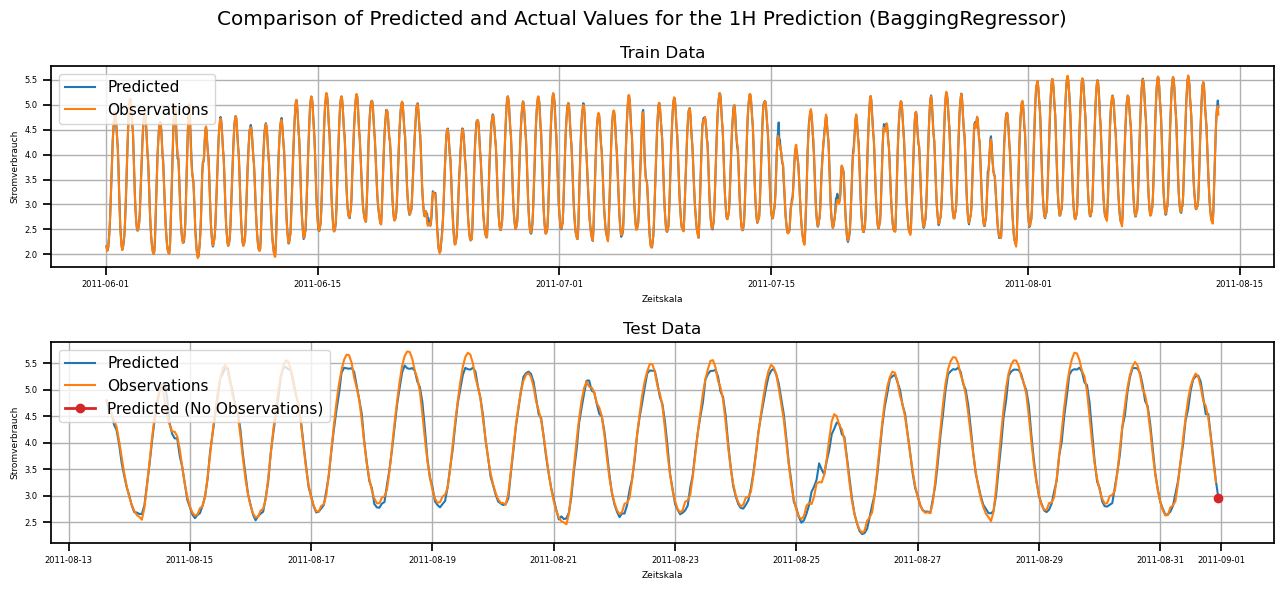

In [64]:
train_results_tree, test_results_tree = run_BaggingRegressor(X_train, y_1H_train, X_test, y_1H_test, 10)
modelMetrics(train_results_tree, test_results_tree)
plot_results(train_results_tree, test_results_tree, 'Comparison of Predicted and Actual Values for the 1H Prediction (BaggingRegressor)')

Von den Zahlenwerten her haben wir eine schockiernd gute Prognose.  
* Der `mae` beträgt 0.019 für die Trainings und 0.076 für die Testdaten. 
* Für den `r2` haben wir Werte von 0.999 und 0.989.
 
Eine derart gute Prognose (trotz Regression Tree) könnte dadruch erklärt werden, dass wir sehr starke rekurrente Strukturen durch die Periodizität der Daten und über den kurzen Zeitraum von 3 Monaten nicht allzu abweichende Werte haben. Zudem ähneln die Werte von der Vorstunde im wesetlichen denen der nachfolgenden, weshalb die Struktur sehr dankbar für einen Regression Tree ist.   
  
Hervorzuheben sind allerdings die Peaks in den Testdaten. Schaut man sich die Predictions dieser in der Grafik an, so kann man sehr gut erkennen, dass diese stets unter den beobachteten Werten liegen. Diese sollten eigentlich in fast allen Fällen einen Wert über 5.5 erreichen.  
Betrachtet man die Trainingsdaten, so liegt der Peak in den meisten Fällen unter 5.5. Dies könnte eine Erklärung sein, warum diese in den Testdaten schlechter vorhergesagt werden, da schlichtweg diese Art der Daten nicht häufig genug vom Modell gesehen wurde.  
Bei weiter in der Zukunft liegenden Daten (September etc. ) wäre die Prognose dementsprechend vorraussichtlich schlechter.

Auch hier wollen wir ausprobieren, ob die Hinzunahme von `'LINEAR_TREND'` die Prognose verbessert und ggf. den Bias verringert.

In [65]:
#Redefine train and test set with added feature
X_trainLin, X_testLin, y_1H_trainLin, y_1H_testLin, _, _ = train_test_split(weather_powerDF, features + ['LINEAR_TREND'])

#Run new Model 
train_results_treeLin, test_results_treeLin = run_BaggingRegressor(X_trainLin, y_1H_trainLin, X_testLin, y_1H_testLin, 10, False)

modelMetrics(train_results_tree, test_results_tree)
modelMetrics(train_results_treeLin, test_results_treeLin)

mae       mse      rmse        r2      corr      bias
Train Data   0.01902  0.000898  0.029966  0.999002  0.999501  0.000325
Test Data   0.076302  0.010343  0.101703  0.989868  0.995376 -0.024401

mae       mse      rmse        r2      corr      bias
Train Data  0.019202  0.000914  0.030226  0.998984  0.999493  0.000232
Test Data   0.074235   0.00967  0.098338  0.990527  0.995584 -0.017939

Die obere Tabelle stellt das Modell ohne `'LINEAR_TREND'` dar, die untere mit. 
Wir konnten in allen Parametern in den Test Daten die Werte etwas verbessern, auch wenn nicht allzu sehr. Besonders nennenswert ist die Reduktion des Bias von -0.024 auf -0.018. Zwar konnten wir so dem vorherig angesprochenem Problem etwas entgegenwirken, aber auch nicht beheben.

# 5.2 Predictions - 24H

TEMPERATURE[C]  HUMIDITY[%]  PRESSURE[bar]  \
Feature Importance         0.04701      0.01372       0.012011   

                    WIND_SPEED[m/s]  RAINFALL[mm]     MONTH       DAY  \
Feature Importance         0.015708      0.003482  0.003535  0.011495   

                        HOUR  TOTAL_LOAD  
Feature Importance  0.056441    0.836598

mae       mse      rmse        r2      corr      bias
Train Data   0.07424  0.013712  0.117099  0.984691  0.992429  -0.00398
Test Data   0.253464  0.107163  0.327357  0.896305  0.953605 -0.114289

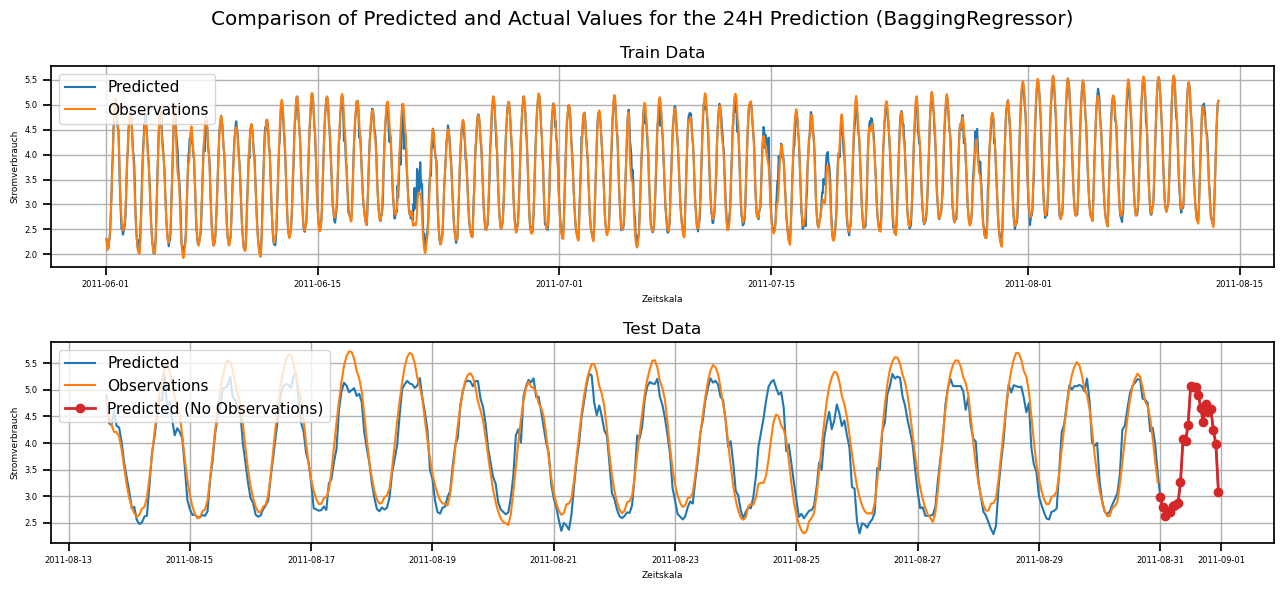

In [66]:
train_results_tree24, test_results_tree24 = run_BaggingRegressor(X_train, y_24H_train, X_test, y_24H_test, 10)
modelMetrics(train_results_tree24, test_results_tree24)
plot_results(train_results_tree24, test_results_tree24, 'Comparison of Predicted and Actual Values for the 24H Prediction (BaggingRegressor)')

Bei der 24H Prognose sind die Predictions im Vergleich deutlich schlechter ausgefallen.  
Was hier besonder gut zu sehen ist, sind die modelltypischen Schwachstellen. Die Monotonie der Daten wurde gar nicht erkannt und an den Extremen der Werte sind starke Abweichungen und schwankende Werte zu erkennen.

Auch eine Anpassung von `n_estimators` liefert keine deutlich besseren Werte. Wir sehen von weiteren Verbesserungen in Anbetracht der Modelltypschen Probleme ab.

In [67]:
for i in range(5, 31, 5):
    train_results_tree24, test_results_tree24 = run_BaggingRegressor(X_train, y_24H_train, X_test, y_24H_test, i, False)
    modelMetrics(train_results_tree24, test_results_tree24)

mae       mse      rmse        r2      corr      bias
Train Data  0.081598  0.018477  0.135932  0.979371  0.989705  -0.00249
Test Data    0.24462  0.105738  0.325174  0.897683  0.951459 -0.082142

mae       mse      rmse        r2      corr      bias
Train Data   0.07424  0.013712  0.117099  0.984691  0.992429  -0.00398
Test Data   0.253464  0.107163  0.327357  0.896305  0.953605 -0.114289

mae       mse      rmse        r2      corr      bias
Train Data  0.072058  0.012237  0.110622  0.986338  0.993277 -0.001869
Test Data   0.252381  0.105388  0.324636  0.898022  0.954502 -0.113886

mae       mse      rmse        r2      corr      bias
Train Data  0.069794  0.011276  0.106188  0.987411  0.993841  -0.00153
Test Data   0.250612  0.103714  0.322046  0.899642  0.955689 -0.116065

mae       mse      rmse        r2      corr      bias
Train Data  0.069493  0.011183   0.10575  0.987515  0.993886  -0.00098
Test Data   0.250082  0.102548  0.320231  0.900771  0.956478 -0.117586

mae       mse      rmse        r2      corr     bias
Train Data  0.068118  0.010525  0.102592  0.988249  0.994262  -0.0013
Test Data   0.249906  0.103055  0.321021   0.90028  0.956332 -0.11688

# 6. Neuronales Netz

In [87]:
seed = 42

#Set seeds for reporducability
def setSeeds(seed):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [70]:
X_train, X_test, y_1H_train, y_1H_test, y_24H_train, y_24H_test = train_test_split(weather_powerDF, features)

In [85]:
def run_NN(X_train, y_train, X_test, y_test):
    setSeeds(420) #set seed for reproducability

    #Scale the values for compatibility
    X_train, X_test = scale([X_train, X_test], StandardScaler())
    y_train, y_test = scale([y_train, y_test], StandardScaler())

    #Define and fit the NNReg model
    NNRegModel = Sequential()
    EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

    NNRegModel.add(InputLayer(shape=[X_train.shape[1]]))
    NNRegModel.add(Dense(8,activation='tanh',use_bias=True))
    NNRegModel.add(Dense(1,use_bias=True))
    
    sgd = SGD(learning_rate=0.1)
    NNRegModel.compile(loss='mean_squared_error', optimizer='sgd')

    NNRegModel.fit(X_train, y_train,
              shuffle=True,
              epochs=50, #300,
              batch_size=1,
              verbose=0,
              validation_data=(X_test, y_test),                  
              callbacks=[EarlyStopping])

    #Predict y values
    y_train_pred = NNRegModel.predict(X_train).ravel()
    y_test_pred = NNRegModel.predict(X_test).ravel()
    
    #Create dataframes with actual and predicted values
    train_results =  createPredObservDF(y_train, y_train_pred, 'Train Data')
    test_results = createPredObservDF(y_test, y_test_pred, 'Test Data')
    
    return train_results, test_results

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


mae       mse      rmse       r2      corr      bias
Train Data  0.058905   0.00735  0.085732  0.99265  0.996535  0.010192
Test Data   0.097087  0.015492  0.124467  0.98635  0.994651 -0.002566

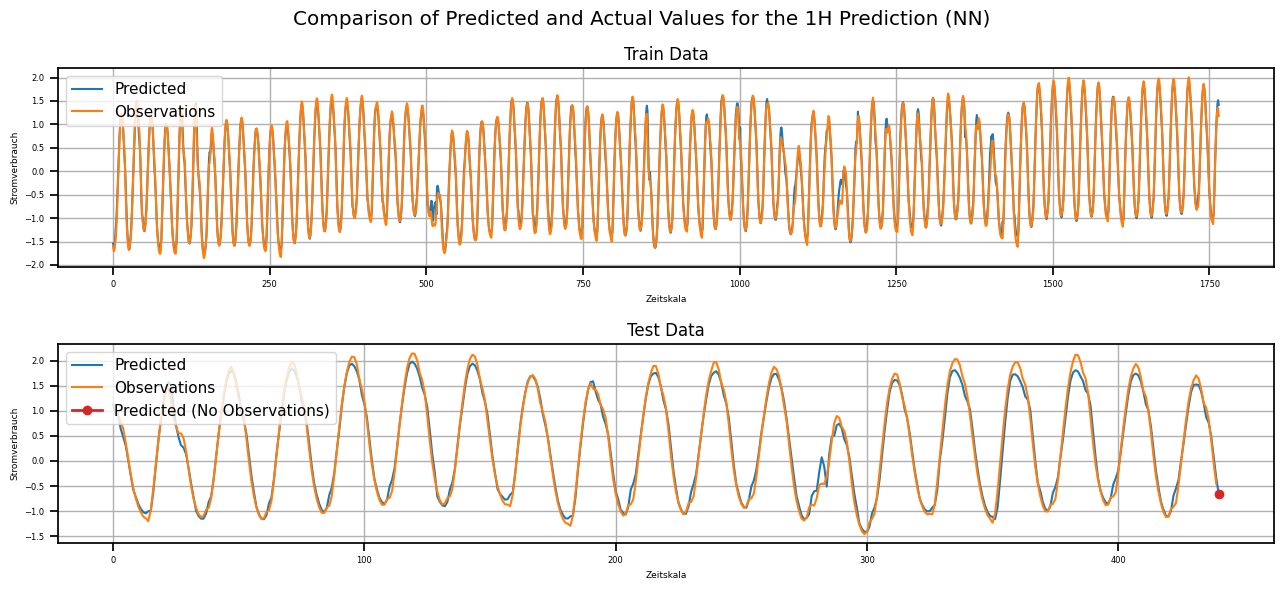

In [72]:
train_results, test_results = run_NN(X_train, y_1H_train, X_test, y_1H_test)
modelMetrics(train_results, test_results)
plot_results(train_results, test_results, 'Comparison of Predicted and Actual Values for the 1H Prediction (NN)')

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


mae       mse      rmse        r2      corr      bias
Train Data  0.187004  0.072197  0.268694  0.927803  0.963829 -0.025543
Test Data   0.228865  0.092663  0.304405  0.919689  0.961415 -0.060792

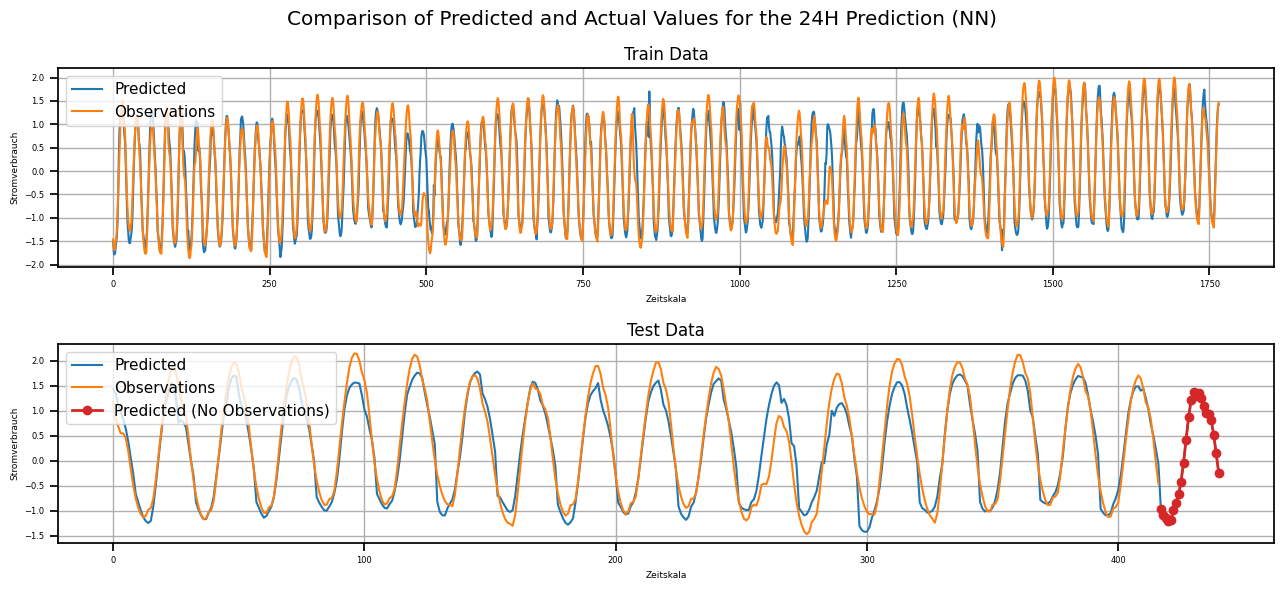

In [86]:
train_results, test_results = run_NN(X_train, y_24H_train, X_test, y_24H_test)
modelMetrics(train_results, test_results)
plot_results(train_results, test_results, 'Comparison of Predicted and Actual Values for the 24H Prediction (NN)')

In [81]:
def run_NN1(X_train, y_train, X_test, y_test):
    setSeeds(420) #set seed for reproducability

    #Scale the values for compatibility
    X_train, X_test = scale([X_train, X_test], StandardScaler())
    y_train, y_test = scale([y_train, y_test], StandardScaler())

    #Define and fit the NNReg model
    NNRegModel = Sequential()

    NNRegModel.add(InputLayer(shape=[X_train.shape[1]]))
    NNRegModel.add(Dense(8,activation='tanh',use_bias=True))
    NNRegModel.add(Dense(1,use_bias=True))
    
    sgd = SGD(learning_rate=0.1)
    NNRegModel.compile(loss='mean_squared_error', optimizer='sgd')

    NNRegModel.fit(X_train, y_train,
              shuffle=True,
              epochs=50, #300,
              batch_size=1,
              verbose=0,
              validation_data=(X_test, y_test))

    #Predict y values
    y_train_pred = NNRegModel.predict(X_train).ravel()
    y_test_pred = NNRegModel.predict(X_test).ravel()
    
    #Create dataframes with actual and predicted values
    train_results =  createPredObservDF(y_train, y_train_pred, 'Train Data')
    test_results = createPredObservDF(y_test, y_test_pred, 'Test Data')
    
    return train_results, test_results

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


mae       mse      rmse       r2      corr      bias
Train Data  0.058905   0.00735  0.085732  0.99265  0.996535  0.010192
Test Data   0.097087  0.015492  0.124467  0.98635  0.994651 -0.002566

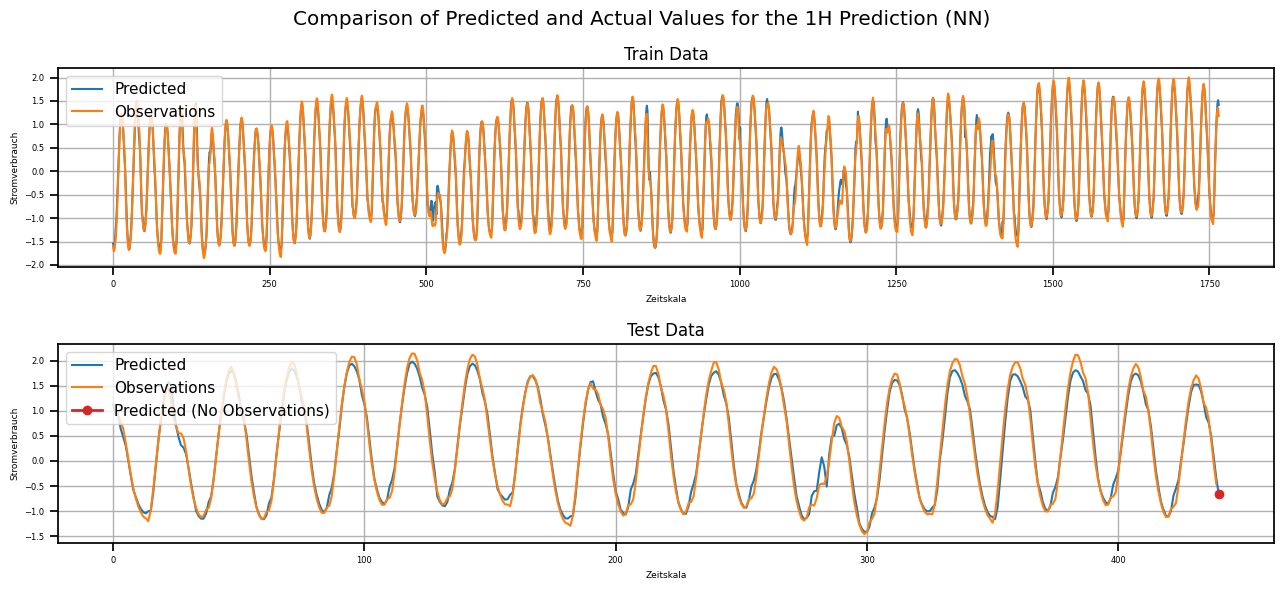

In [83]:
train_results, test_results = run_NN1(X_train, y_1H_train, X_test, y_1H_test)
modelMetrics(train_results, test_results)
plot_results(train_results, test_results, 'Comparison of Predicted and Actual Values for the 1H Prediction (NN)')

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


mae       mse      rmse        r2      corr      bias
Train Data  0.187004  0.072197  0.268694  0.927803  0.963829 -0.025543
Test Data   0.228865  0.092663  0.304405  0.919689  0.961415 -0.060792

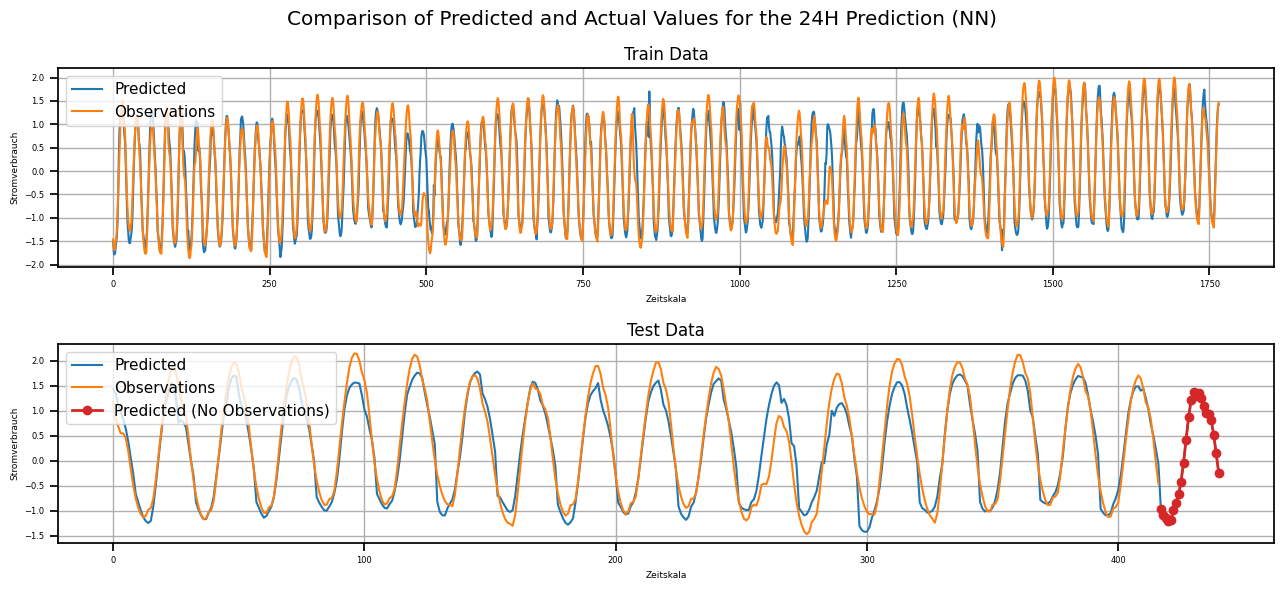

In [84]:
train_results, test_results = run_NN1(X_train, y_24H_train, X_test, y_24H_test)
modelMetrics(train_results, test_results)
plot_results(train_results, test_results, 'Comparison of Predicted and Actual Values for the 24H Prediction (NN)')

# 7. Vergleich der Modelle

In diesem Kapitel sollen die 3 vorher behandelten verschiedenen Modelle miteinander verglichen werden. Dabei werden die in 3.3.2 aufgelisteten Metriken `mae`, `mse`, `rmse`, `corr`, `r2` und `bias` untersucht. Nachfolgend sind die einzelen (bereits jeweils optimierten) Werte für die Test-Daten in einer Tabelle aufgelistet, um einen direkten Vergleich zu erhalten.

## 7.1 Vergleich der 1H-Predictions

|   |mae|mse |rmse|corr|r2|bias
|:--|:--|:--|:--|:--|:--|:--
|Multivariates Lineares Modell|0.101167|0.015702|0.125307|0.984619|0.992685|-0.025106
|Regression Tree|0.074235|0.00967|0.098338|0.990527|0.995584|-0.017939
|Neuronales Netz|0.097087|0.015492|0.124467|0.98635|0.994651|-0.002566

## 7.2 Vergleich der 24H-Predictions

|   |mae|mse |rmse|corr|r2|bias
|:--|:--|:--|:--|:--|:--|:--
|Multivariates Lineares Modell|0.199196|0.087757|0.296239|0.915082|0.959398|0.07368
|Regression Tree|0.24462|0.105738|0.325174|0.897683|0.951459|-0.082142
|Neuronales Netz|0.228865|0.092663|0.304405|0.919689|0.961415|-0.060792